In [1]:
# dependencies
from random import randint
import pandas as pd
from plotnine import (
    ggplot,
    aes,
    geom_tile,
    geom_col,
    geom_bar,
    geom_line,
    geom_point,
    facet_grid,
)

In [2]:
# support methods
def supplement_targets(targets, districts, n=10):
    out = set(targets)
    runs = 0
    while (len(out) < n) & (runs < 100): 
        out.add(districts[randint(0, len(districts)-1)])
        runs += 1
    return out

In [3]:
# main
full_mp = pd.read_parquet("../../US-II-MP/export/output/mp.parquet")
mp = full_mp.loc[full_mp.year_occurred < 2023].copy()
extras = pd.read_parquet("../import/input/extras.parquet")

targets = ['2', '8', '9', '19', '20', '24']
sample_districts = supplement_targets(targets, mp.city_district_occurred.unique())

### what data did we receive about when incidents were closed?
In the first version of this database (covering 2000-2020), we received two separate columns that refer to when cases were last interacted with by CPD: `LAST UPDATE` and `CLOSED DATE`.

In the sixth version of the database (covering 2000-2022), we received the same fields as one single column, labeled `LAST UPDATE/CLOSED DATE`, which gives us pause about how to interpret this timestamp.
* **Sanity Check:** _Were these two fields equivalent in our earlier version?_
    We reviewed the records in the first version and found that for some 1200 records, the last reported update and the reported closed date are not the same date. In fact, when it differs, the last update is reported as being days, months, or even years later than the reported closed date. It's unclear what kind of updates would occur after an incident has been closed. 

When in doubt, we would defer to treating `LAST UPDATE/CLOSED DATE` as another `LAST UPDATE` field, so that we don't inaccurately describe any records as being "closed". This means we will only have `closed_date` through the end of 2020.

##### Options
- **A:** Only analyze CPD closure rates through 2020
- **B:** Use the day of the last update as a stand-in for day of case closure. NOTE: 

Since we have a reported `status` for every record through 2022, we can verify that we only apply the fix in **option B** to records with the keyword "CLOSED" in the status. This allows us to salvage that field and include closure rate in analysis through 2022. 

Given what we learned about the relationship between the last update and the closed date from the first version, `last_update` to be a stand-in for `closed_date` for 2021-2022 records, as the raw field name suggests we can reasonably do, we wi

If we calculate `time_to_close` as the time between `date_officer_arrived` and `closed_date`, we will 

In [4]:
mp.loc[mp.last_update.dt.date == mp.closed_date].shape[0]

351251

## sanity check: what is the coverage of `closed_date`?

In [5]:
# support methods
def load_version(srcdir, version, cols=None):
    f = f"{srcdir}/{version}.parquet"
    if cols:
        df = pd.read_parquet(f)
        less = df[[col for col in df.columns if col in cols]]
        return less
    return pd.read_parquet(f)

version_srcdir = "../../US-II-MP/export/output/versions"
first = load_version(version_srcdir, "first", 
                     cols=['rd_no', 'last_update', 'closed_date'])

In [6]:
mismatch = [tup.rd_no for tup in first.itertuples() 
            if (pd.notna(tup.last_update)) & 
            (pd.notna(tup.closed_date)) & 
            (tup.last_update != tup.closed_date)]
mismatch_df = first.loc[first.rd_no.isin(mismatch), ['last_update', 'closed_date']]
assert all(mismatch_df.last_update > mismatch_df.closed_date)
print(f"{mismatch_df.shape[0]} records found with `last_update` later than `closed_date`")

1235 records found with `last_update` later than `closed_date`


In [7]:
any(mp.status.isna())

False

In [8]:
mp.closed_date.max()

Timestamp('2023-04-24 00:00:00')

In [9]:
mp.last_update.max()

Timestamp('2023-04-24 20:52:00')

In [10]:
(mismatch_df.last_update - mismatch_df.closed_date).describe()

count                           1235
mean     173 days 15:45:37.165991902
std      408 days 19:12:31.468947576
min                  1 days 00:00:00
25%                 22 days 00:00:00
50%                 71 days 00:00:00
75%                173 days 00:00:00
max               7284 days 00:00:00
dtype: object

In [11]:
mp.DTC1.describe()

count                        352111
mean     26 days 07:24:39.477096711
std      95 days 07:14:50.133731676
min               -1 days +01:45:00
25%                 7 days 15:25:00
50%                12 days 06:30:00
75%                22 days 08:30:00
max              6169 days 09:00:00
Name: DTC1, dtype: object

In [12]:
mp.DTC1_group.value_counts()

DTC1_group
Under 2 weeks     128630
Under 1 month      92340
Under 1 week       70328
Under 6 months     55070
Under 1 year        3418
Over a year         1969
MISSING              601
NEGATIVE             356
Name: count, dtype: int64

In [13]:
mp.DTC1_group_long.value_counts()

DTC1_group_long
under 14 days        128614
under 30 days         92290
under 7 days          65050
more than 30 days     60440
under 48 hours         3308
under 12 hours         1145
under 24 hours          872
MISSING                 601
NEGATIVE                356
under 1 hour             36
Name: count, dtype: int64

In [14]:
mp.closed_date.describe()

count                        352111
mean     2009-08-13 00:21:13.262124
min             2000-01-05 00:00:00
25%             2004-04-14 00:00:00
50%             2008-09-18 00:00:00
75%             2014-06-11 00:00:00
max             2023-04-24 00:00:00
Name: closed_date, dtype: object

In [15]:
mp.last_update.describe()

count                        352710
mean     2009-08-21 12:27:07.344597
min             1999-11-12 19:35:00
25%             2004-04-17 10:04:00
50%             2008-09-25 14:53:30
75%             2014-06-19 22:31:00
max             2023-04-24 20:52:00
Name: last_update, dtype: object

In [16]:
mp.last_update.min()

Timestamp('1999-11-12 19:35:00')

In [17]:
mp.loc[mp.last_update == mp.last_update.min(), 
['rd_no', 'date_occurred', 
 'date_officer_arrived', 'notification_time', 
 'closed_date', 'last_update']]

,rd_no,date_occurred,date_officer_arrived,notification_time,closed_date,last_update
173347,HP105896,2008-01-01,2008-01-04 12:50:00,2008-01-04 13:55:00,2008-01-16,1999-11-12 19:35:00


In [18]:
mp.status_date.describe()

count                        337692
mean     2009-01-30 20:45:02.018318
min             2000-01-05 14:33:02
25%      2004-02-04 19:47:41.250000
50%      2008-05-09 13:22:16.500000
75%      2013-08-02 14:42:45.250000
max             2021-06-02 21:40:55
Name: status_date, dtype: object

## _Highlights_

- for every district that remained active after 2020, reported closure rates plummeted from 2020 onward
- for every district active between 2000-2023, reported notifications to the missing persons section never dropped below 80%
- reported rates of officer arrival vary by district and year.
    * for districts `[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 21, 31]`: officer arrival is consistently reported above 80% of the time. 
        - Note that districts 13 and 21 were no longer in use after 2012 and district 31 was first observed in 2023.
    * for districts `[1, 11, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25]`: reported officer arrival is extremely inconsistent across the period. 
        - District 23 began consistent in early years but plummeted just before being taken out of directory in 2012.
    * for districts `[11, 14, 15, 16, 17, 19, 20, 24, 25]`: officer arrival trends plummeted around 2018, prior to the start of the pandemic in early 2020
    * for districts `[2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 22, 25]`: officer arrival reporting rates either continue to trend upwards or remain above 70% even through the first two years of the pandemic

In [19]:
sorted(mp.columns)

['DTC1',
 'DTC1_group',
 'DTC1_group_long',
 'DTC2',
 'DTC2_group',
 'DTC2_group_long',
 'DTC3',
 'DTC3_group',
 'DTC3_group_long',
 'address',
 'age',
 'age_group',
 'age_is_estimate',
 'age_w_unit',
 'beat_assigned',
 'beat_occurred',
 'city_beat_occurred',
 'city_district_occurred',
 'city_sector_occurred',
 'closed_date',
 'closure_is_estimate',
 'current_iucr',
 'current_primary_class',
 'current_secondary_class',
 'date_last_missing',
 'date_occurred',
 'date_officer_arrived',
 'dental_records',
 'description',
 'det_inv_assgn_first_name',
 'det_inv_assgn_last_name',
 'det_inv_assgn_star',
 'det_status_time',
 'estimated_age',
 'fingerprints',
 'flash_message_sent',
 'given_age_group',
 'how_located',
 'juvenile',
 'last_update',
 'length_missing',
 'medical_records',
 'no__times_missing',
 'no_age_data',
 'no_basic_profile',
 'no_beat_data',
 'notif_made_to_time',
 'notification_by_first_name',
 'notification_by_last_name',
 'notification_by_star',
 'notification_time',
 'notifi

In [20]:
df = pd.DataFrame(mp.loc[mp.city_district_occurred.isin(sample_districts), 
                         ['city_district_occurred', 'year_occurred']
                        ].value_counts()).reset_index()
df

,city_district_occurred,year_occurred,count
0,24,2010,1806
1,24,2011,1792
2,2,2013,1780
3,2,2012,1644
4,24,2012,1610
...,...,...,...
225,19,2011,155
226,14,2020,151
227,19,2010,148
228,14,2022,146


/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.p

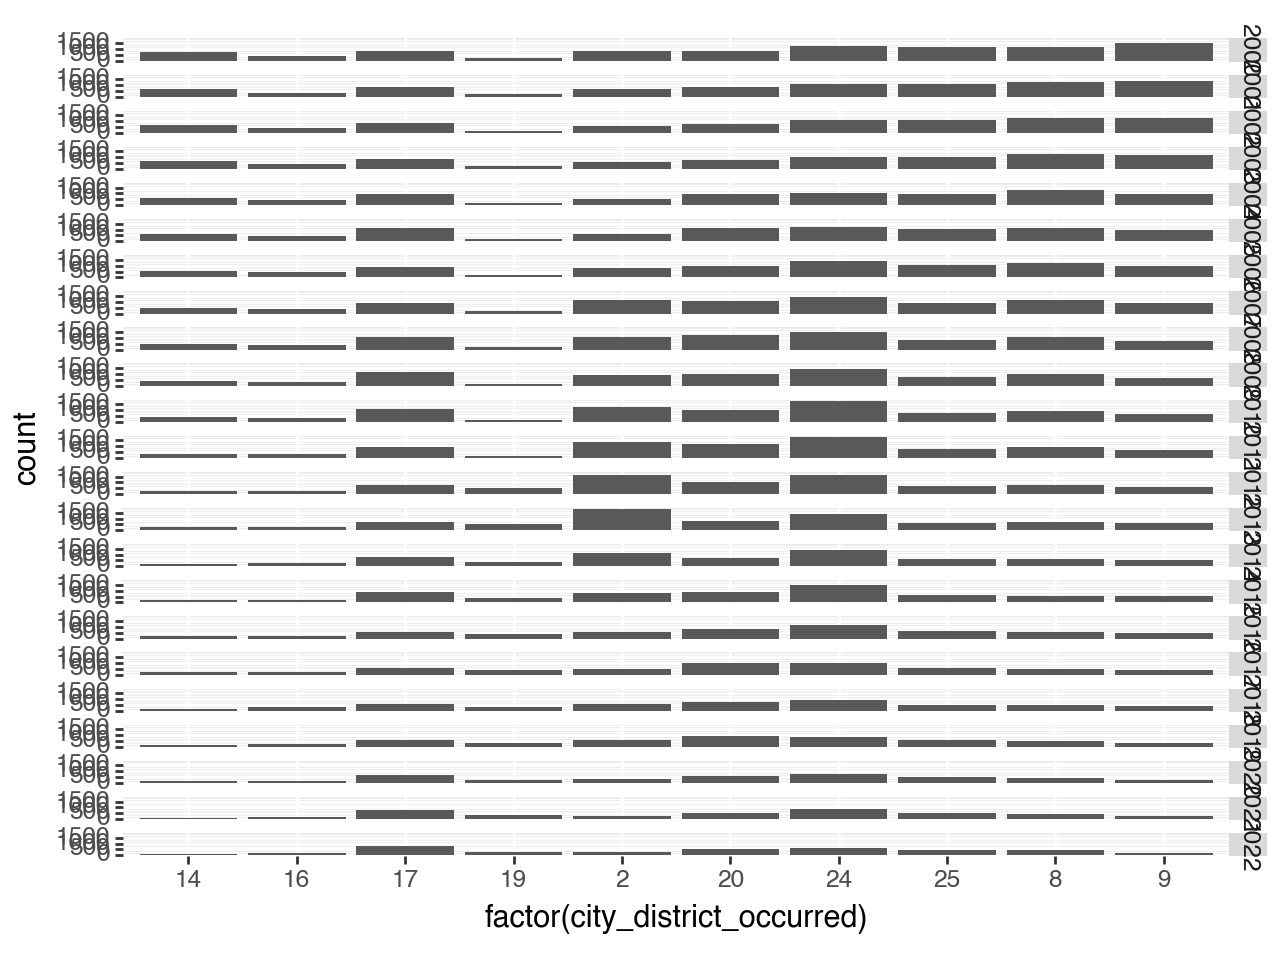

<Figure Size: (640 x 480)>

In [21]:
(ggplot(df, aes('factor(city_district_occurred)', 'count'))
 + geom_col()
 + facet_grid('year_occurred ~ .')
)

## `year_occurred`

In [22]:
mp[['rd_no', 'year_occurred', 'city_district_occurred']]

,rd_no,year_occurred,city_district_occurred
0,F012033,2000,3
1,F021758,2000,14
2,F094577,2000,14
3,F121480,2000,13
4,F118317,2000,2
...,...,...,...
301,HW137496,2013,None
305,HW220644,2013,None
310,HW278331,2013,None
318,HW530680,2013,None


In [23]:
df = pd.DataFrame(mp[['year_occurred', 'city_district_occurred']].value_counts()).reset_index()
sample_df = df.loc[df.city_district_occurred.isin(sample_districts)].copy()
df

,year_occurred,city_district_occurred,count
0,2010,24,1806
1,2011,24,1792
2,2013,2,1780
3,2012,2,1644
4,2012,24,1610
...,...,...,...
540,2011,1,68
541,2000,1,64
542,2007,1,62
543,2001,1,43


/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py:22

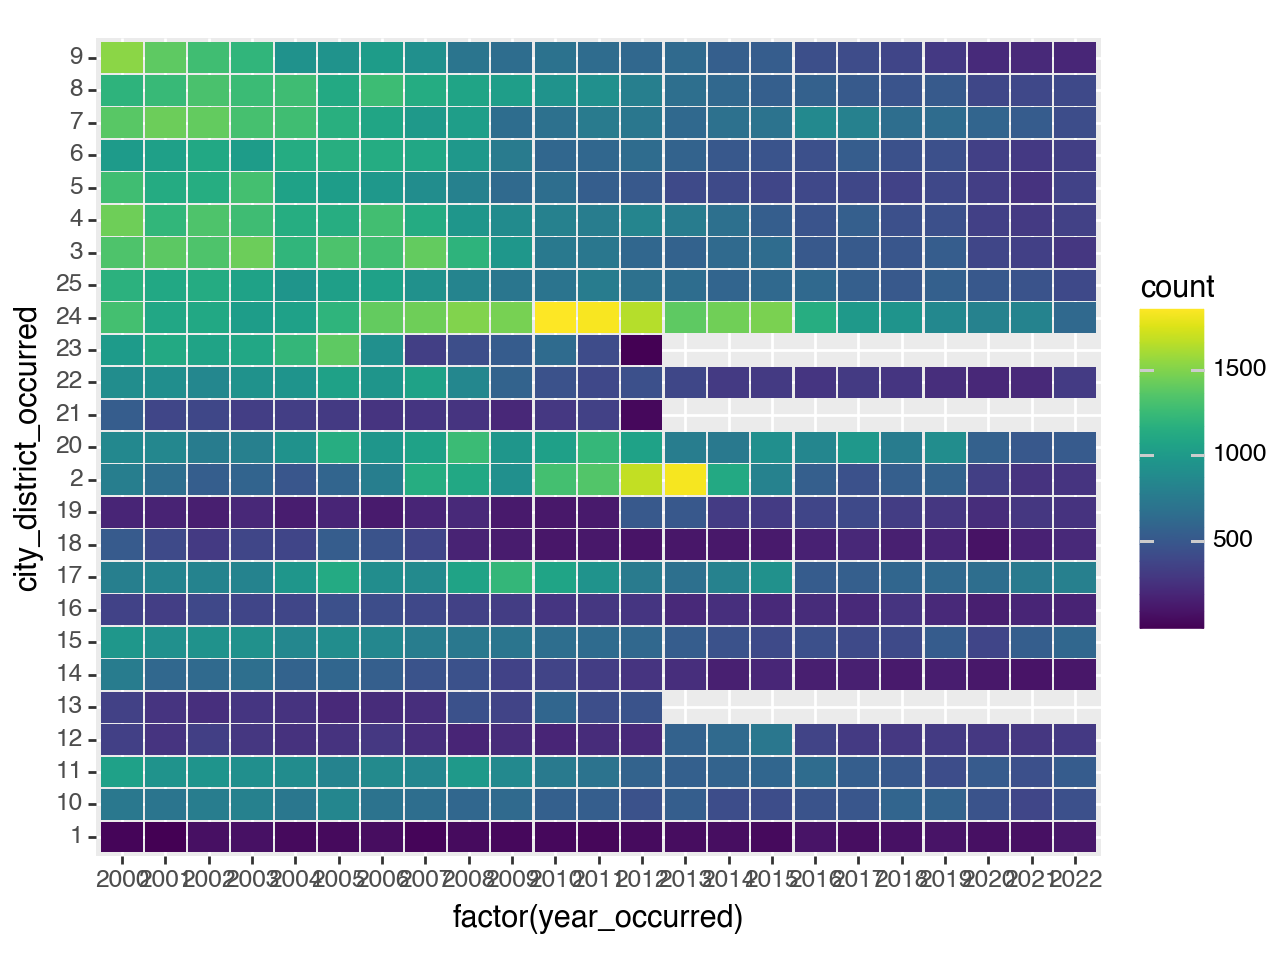

<Figure Size: (640 x 480)>

In [24]:
(ggplot(df, aes('factor(year_occurred)', 'city_district_occurred', fill='count'))
 + geom_tile(aes(width=.95, height=.95))
)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py:22

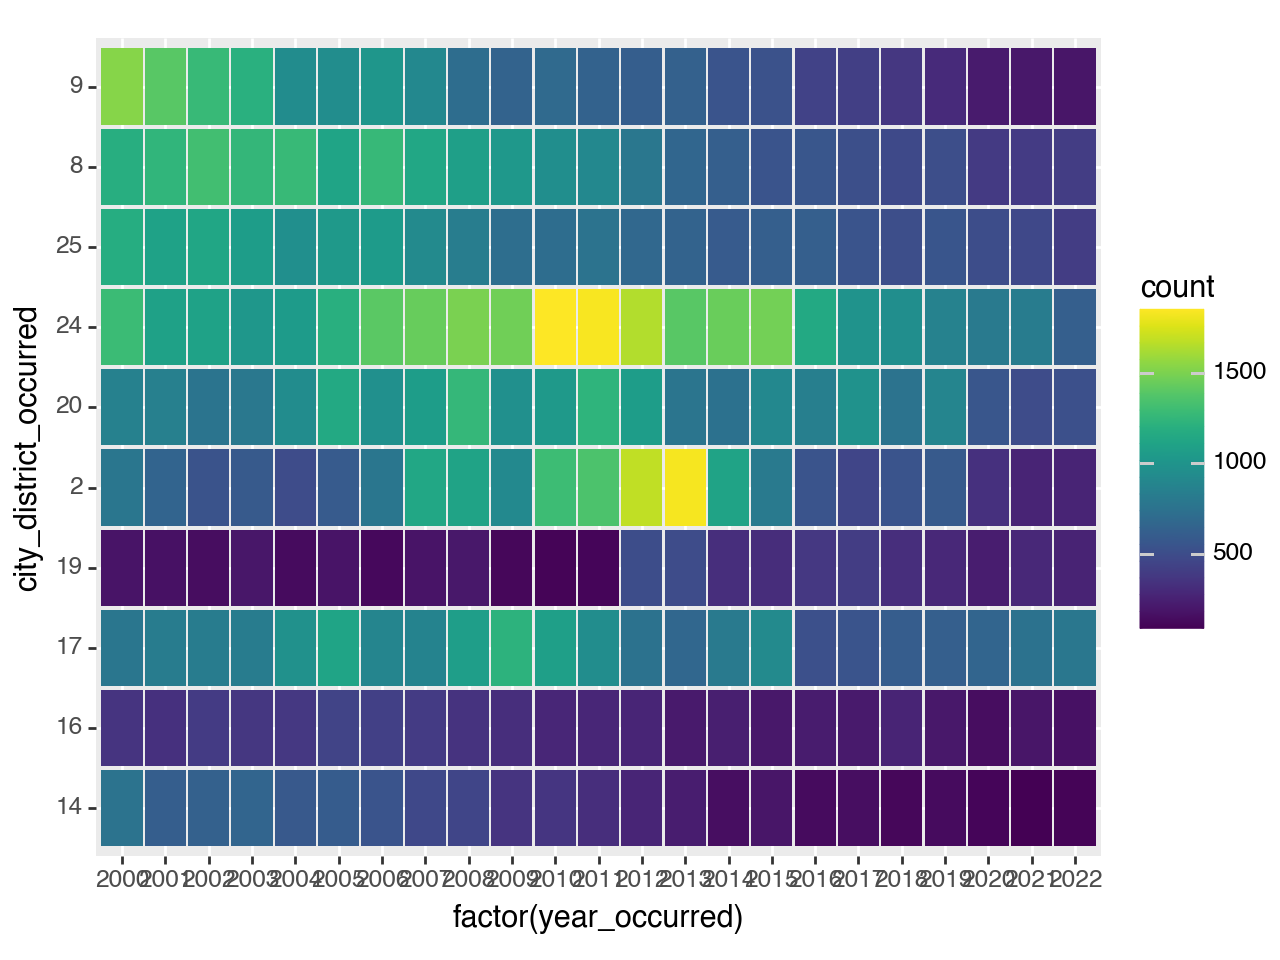

<Figure Size: (640 x 480)>

In [25]:
(ggplot(sample_df, aes('factor(year_occurred)', 'city_district_occurred', fill='count'))
 + geom_tile(aes(width=.95, height=.95))
)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.p

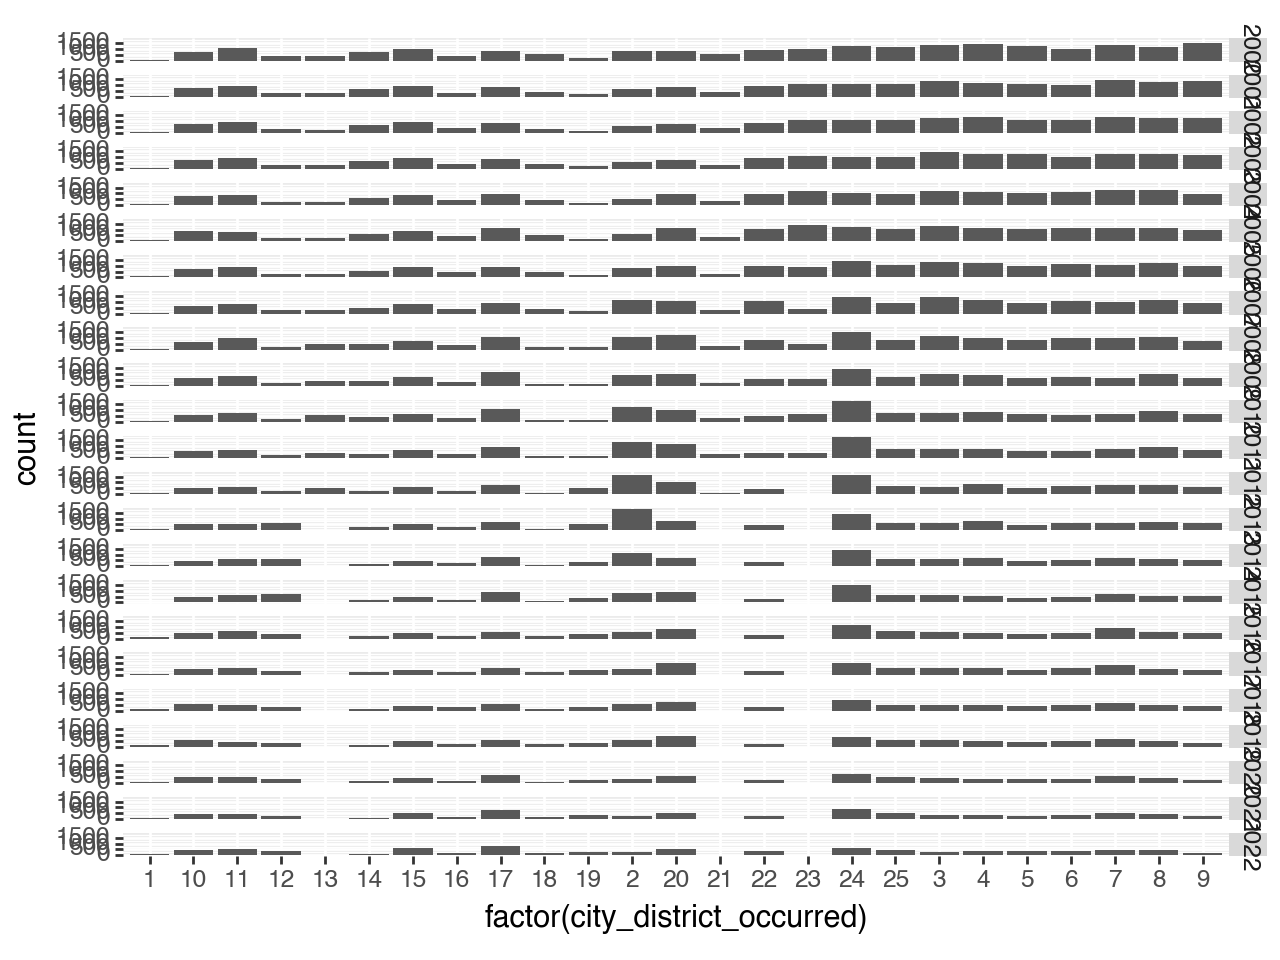

<Figure Size: (640 x 480)>

In [26]:
(ggplot(df, aes('factor(city_district_occurred)', 'count'))
 + geom_col()
 + facet_grid('year_occurred ~ .')
)

*****why are there `None`s*****

In [27]:
no_dist_oad = mp.loc[(mp.city_district_occurred.isna()) & (mp.tta_group == 'MISSING'), 'rd_no'].unique()
mp.loc[mp.rd_no.isin(no_dist_oad), ['rd_no', 'race', 'sex', 'age_group']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 270 entries, 4617 to 352824
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rd_no      270 non-null    object
 1   race       268 non-null    object
 2   sex        268 non-null    object
 3   age_group  269 non-null    object
dtypes: object(4)
memory usage: 10.5+ KB


- maybe outside jurisdiction?

In [28]:
mp.loc[mp.rd_no.isin(no_dist_oad), ['beat_occurred', 'beat_assigned']] # what is the issue here?

,beat_occurred,beat_assigned
4617,NaN,1102
4717,NaN,1524
6185,NaN,0121
7477,NaN,9172
8576,NaN,1135
...,...,...
351644,NaN,9154
351774,NaN,2513
351977,NaN,2402
351980,NaN,1831


## missing officer timestamps
- `time_to_arrive`
- `time_to_notify`
- `time_to_close`

In [29]:
df = mp[['year_occurred', 'city_district_occurred',
         'date_officer_arrived', 'notification_time', 'closed_date',
         'tta_group', 'ttn_group', 'ttc_group']].copy()
df['arrival_reported'] = df.date_officer_arrived.notna()
df['notification_reported'] = df.notification_time.notna()
df['closure_reported'] = df.closed_date.notna()
df['count'] = 1
df

,year_occurred,city_district_occurred,date_officer_arrived,notification_time,closed_date,tta_group,ttn_group,ttc_group,arrival_reported,notification_reported,closure_reported,count
0,2000,3,2000-01-06 18:55:00,2000-01-06 20:16:00,2000-01-15,more than 120 min,under 12 hours,under 14 days,True,True,True,1
1,2000,14,2000-01-11 13:40:00,2000-01-11 14:27:00,2000-01-16,more than 120 min,under 1 hour,under 7 days,True,True,True,1
2,2000,14,2000-02-16 12:00:00,NaT,2000-03-08,more than 120 min,MISSING,under 30 days,True,False,True,1
3,2000,13,2000-02-29 13:40:00,2000-02-29 16:45:00,2000-03-17,more than 120 min,under 12 hours,under 30 days,True,True,True,1
4,2000,2,2000-02-28 00:45:00,2000-02-28 02:27:00,2000-03-24,more than 120 min,under 12 hours,under 30 days,True,True,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...
301,2013,None,NaT,NaT,NaT,None,None,None,False,False,False,1
305,2013,None,NaT,NaT,NaT,None,None,None,False,False,False,1
310,2013,None,NaT,NaT,NaT,None,None,None,False,False,False,1
318,2013,None,NaT,NaT,NaT,None,None,None,False,False,False,1


In [30]:
report_rates = df[['year_occurred', 'city_district_occurred', 
                   'arrival_reported', 'notification_reported', 'closure_reported', 
                   'count']].groupby(
    ['year_occurred', 'city_district_occurred']).sum().reset_index()

In [31]:
report_rates.loc[report_rates.year_occurred > 2020, 
                 ['year_occurred', 'city_district_occurred', 'closure_reported']]

,year_occurred,city_district_occurred,closure_reported
501,2021,1,108
502,2021,10,409
503,2021,11,469
504,2021,12,315
505,2021,14,131
506,2021,15,555
507,2021,16,221
508,2021,17,759
509,2021,18,197
510,2021,19,318


In [32]:
report_rates = df[['year_occurred', 'city_district_occurred', 
                   'arrival_reported', 'notification_reported', 'closure_reported', 
                   'count']].groupby(
    ['year_occurred', 'city_district_occurred']).sum().reset_index()
report_rates['arrival'] = report_rates.arrival_reported / report_rates['count']
report_rates['notification'] = report_rates.notification_reported / report_rates['count']
report_rates['closure'] = report_rates.closure_reported / report_rates['count']
report_rates = report_rates[['year_occurred', 
                             'city_district_occurred', 
                             'arrival', 
                             'notification', 
                             'closure']]
report_rates

,year_occurred,city_district_occurred,arrival,notification,closure
0,2000,1,0.968750,0.781250,1.000000
1,2000,10,0.987952,0.874163,1.000000
2,2000,11,0.988450,0.869105,1.000000
3,2000,12,0.989305,0.868984,1.000000
4,2000,13,0.997354,0.865079,1.000000
...,...,...,...,...,...
540,2022,5,0.997396,0.992188,0.945312
541,2022,6,0.991781,0.989041,0.917808
542,2022,7,0.975281,0.991011,0.871910
543,2022,8,0.971897,0.990632,0.871194


In [33]:
report_rates_tidy = pd.melt(report_rates, 
                            id_vars=['year_occurred', 'city_district_occurred'],
                            value_vars=['arrival', 'notification', 'closure'], 
                            var_name='report_type', value_name='report_rate(%)')
report_rates_tidy

,year_occurred,city_district_occurred,report_type,report_rate(%)
0,2000,1,arrival,0.968750
1,2000,10,arrival,0.987952
2,2000,11,arrival,0.988450
3,2000,12,arrival,0.989305
4,2000,13,arrival,0.997354
...,...,...,...,...
1630,2022,5,closure,0.945312
1631,2022,6,closure,0.917808
1632,2022,7,closure,0.871910
1633,2022,8,closure,0.871194


### district 1

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

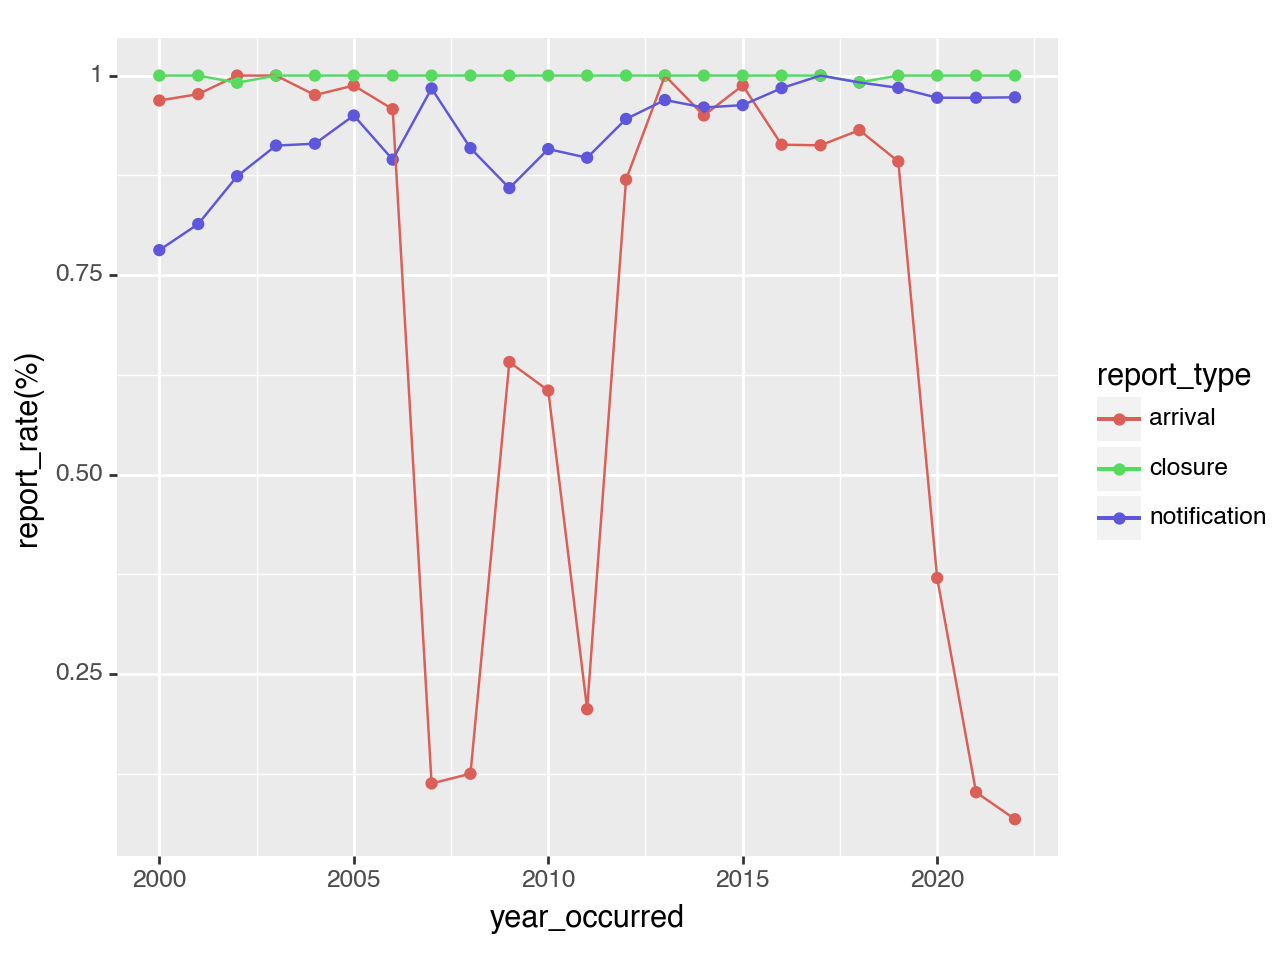

<Figure Size: (640 x 480)>

In [34]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '1', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

- For District 1, between roughly 2006 and 2012, officer arrival times were reported at a significantly lower rate than in periods leading up to (2000-2006) and following (2012-2019)

### district 2

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

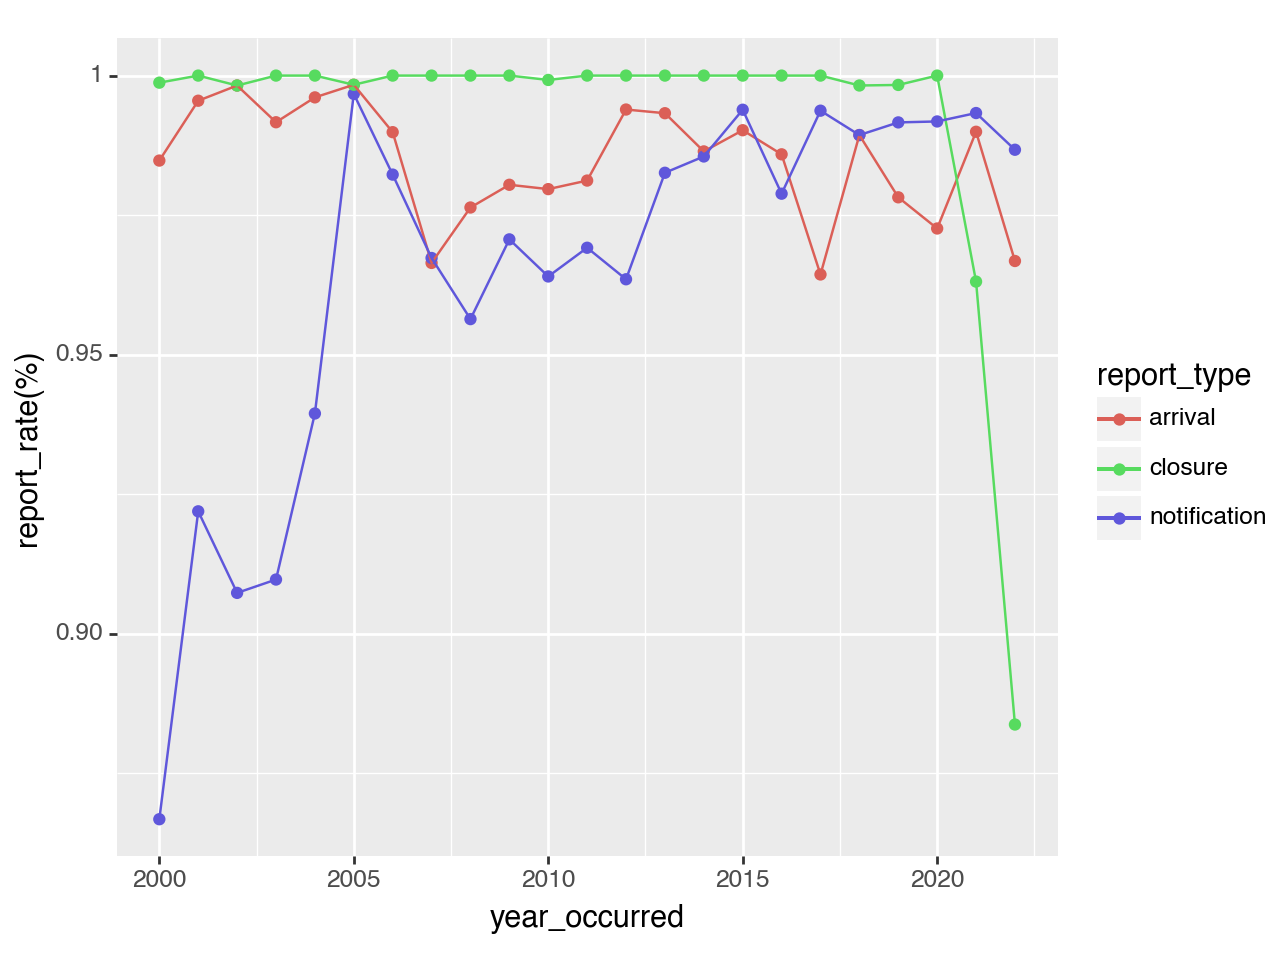

<Figure Size: (640 x 480)>

In [35]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '2', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 3

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

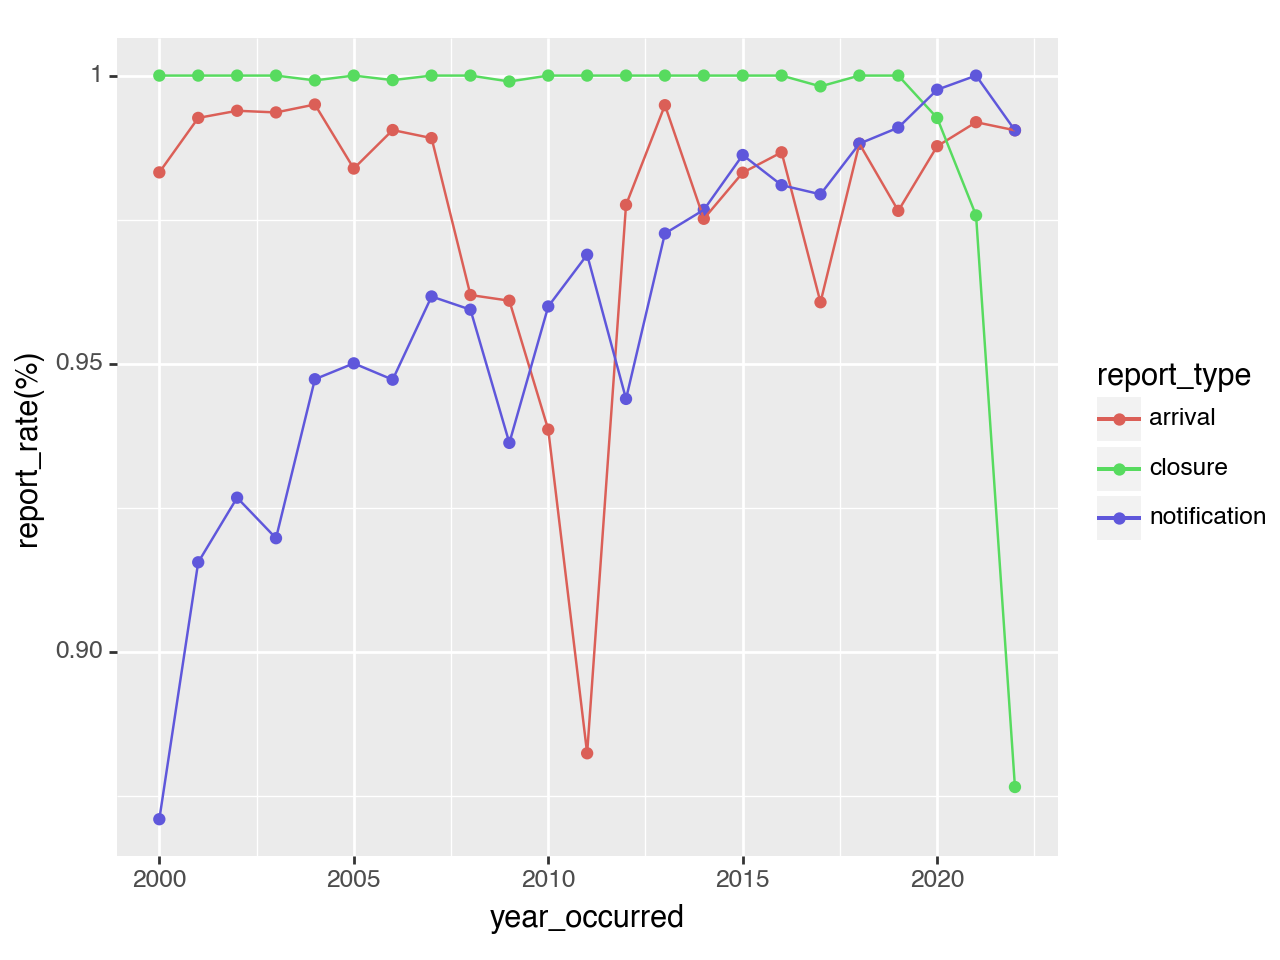

<Figure Size: (640 x 480)>

In [36]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '3', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 4

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

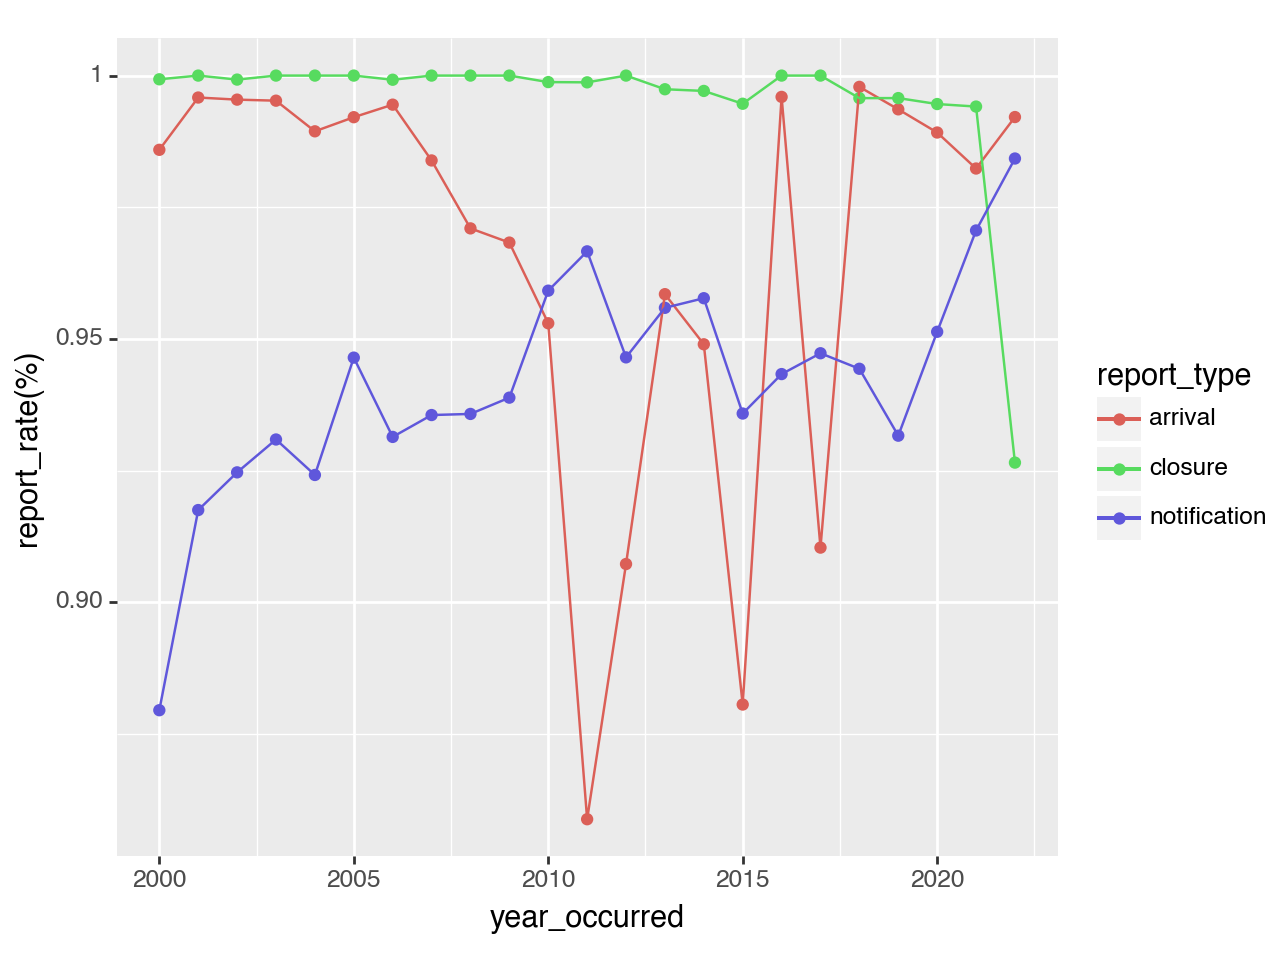

<Figure Size: (640 x 480)>

In [37]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '4', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 5

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

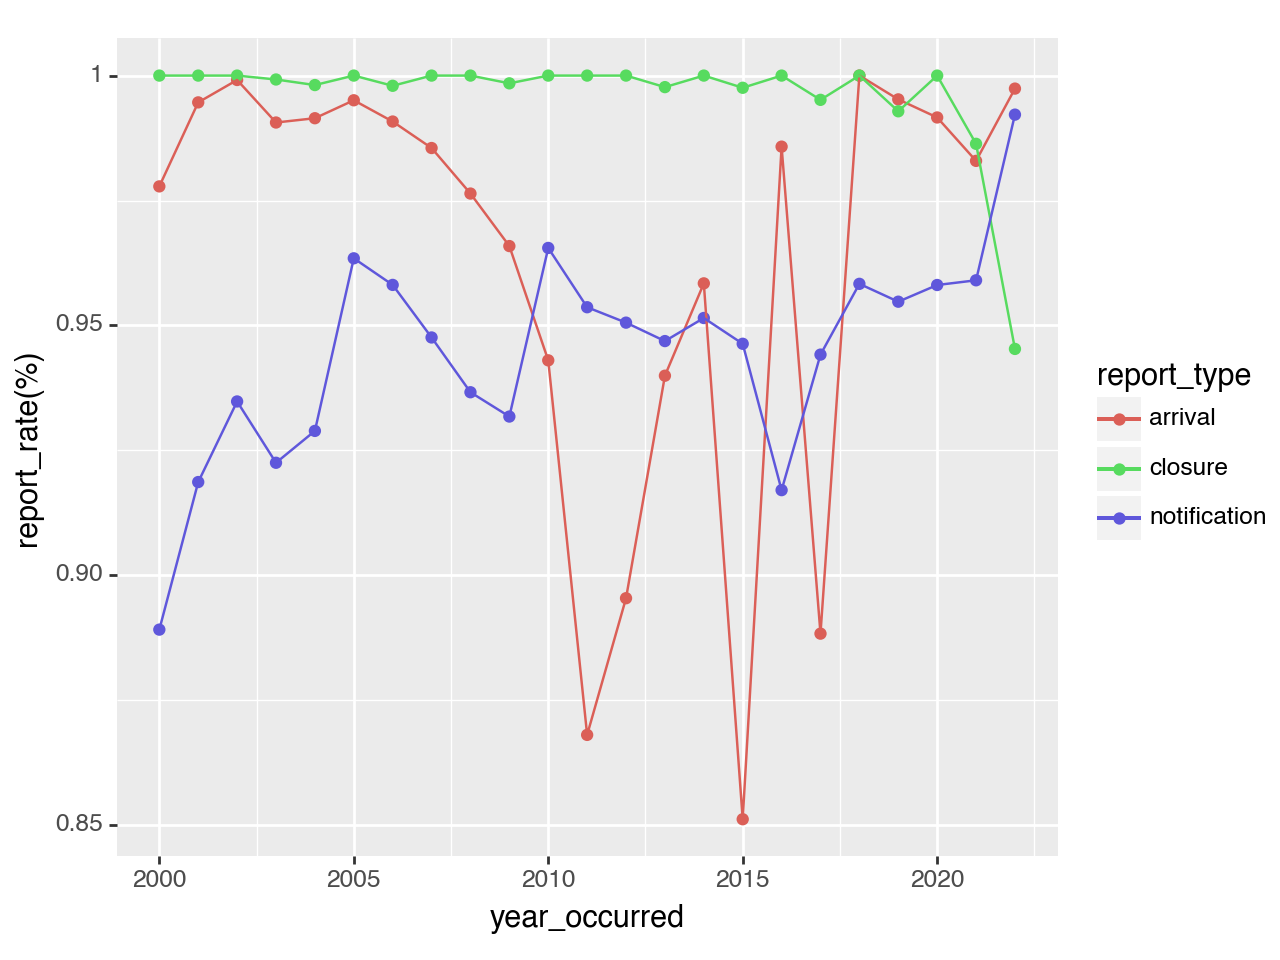

<Figure Size: (640 x 480)>

In [38]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '5', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 6

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

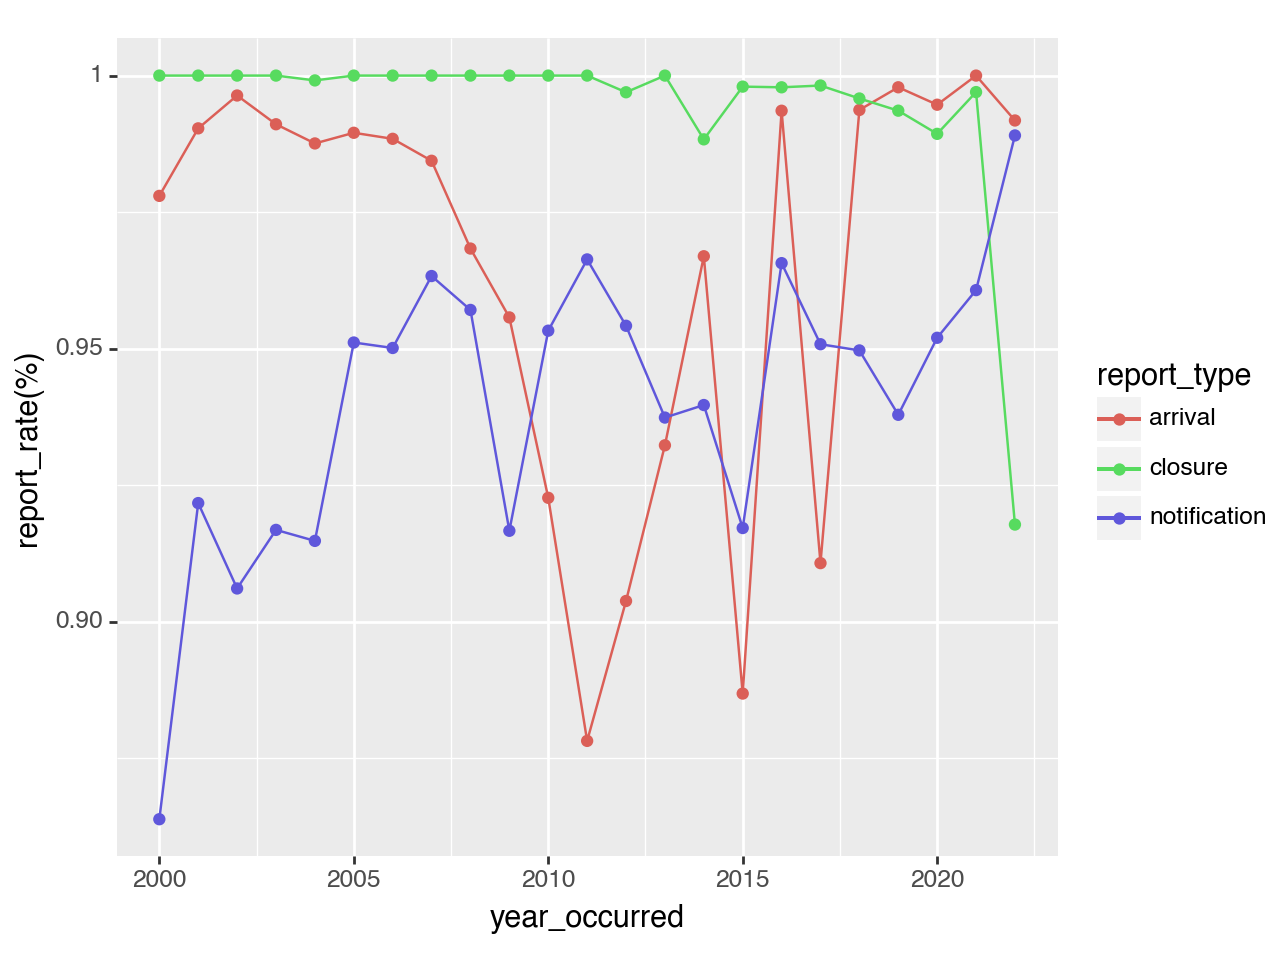

<Figure Size: (640 x 480)>

In [39]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '6', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 7

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

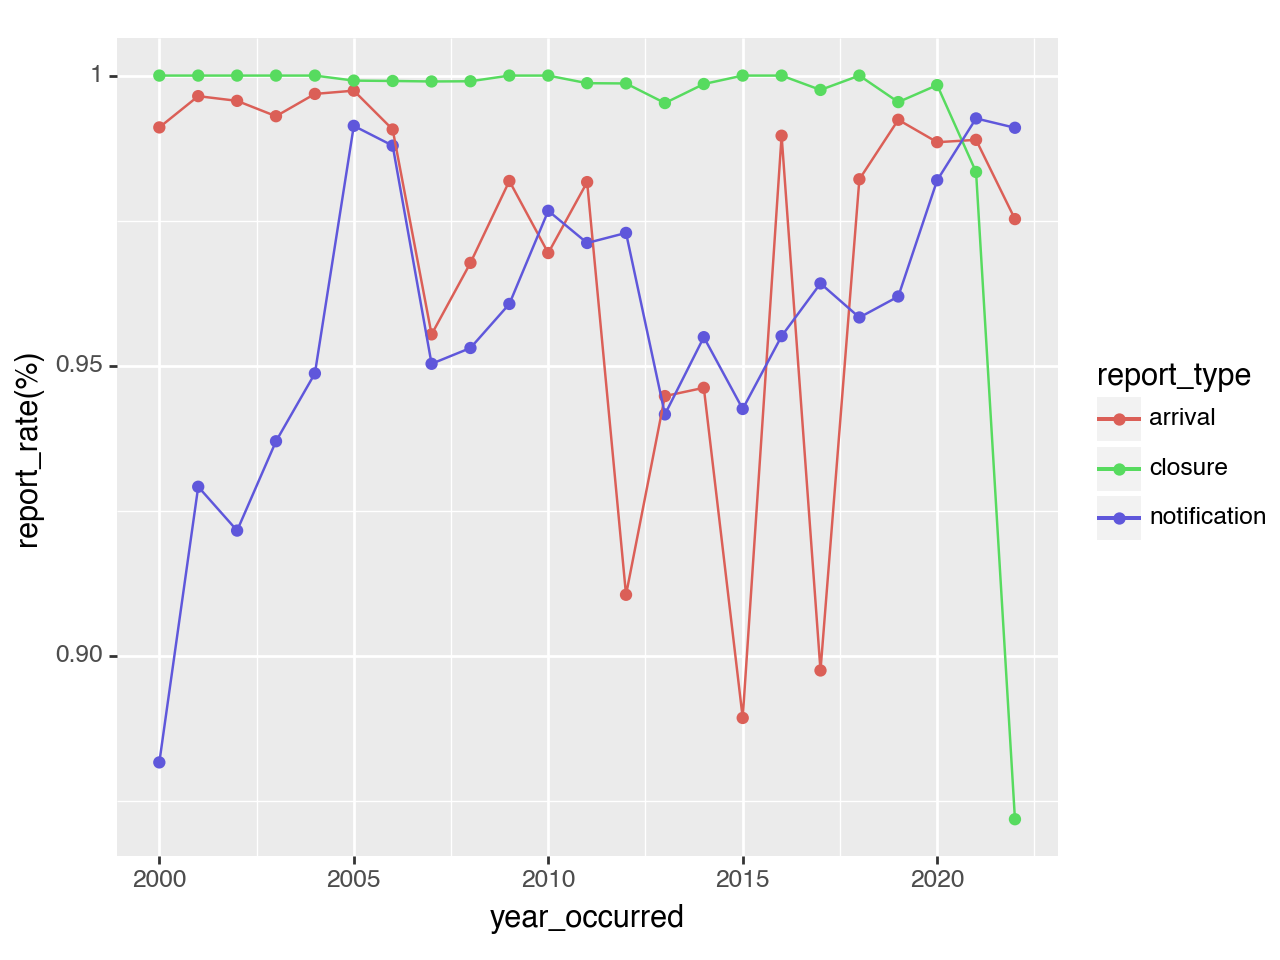

<Figure Size: (640 x 480)>

In [40]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '7', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 8

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

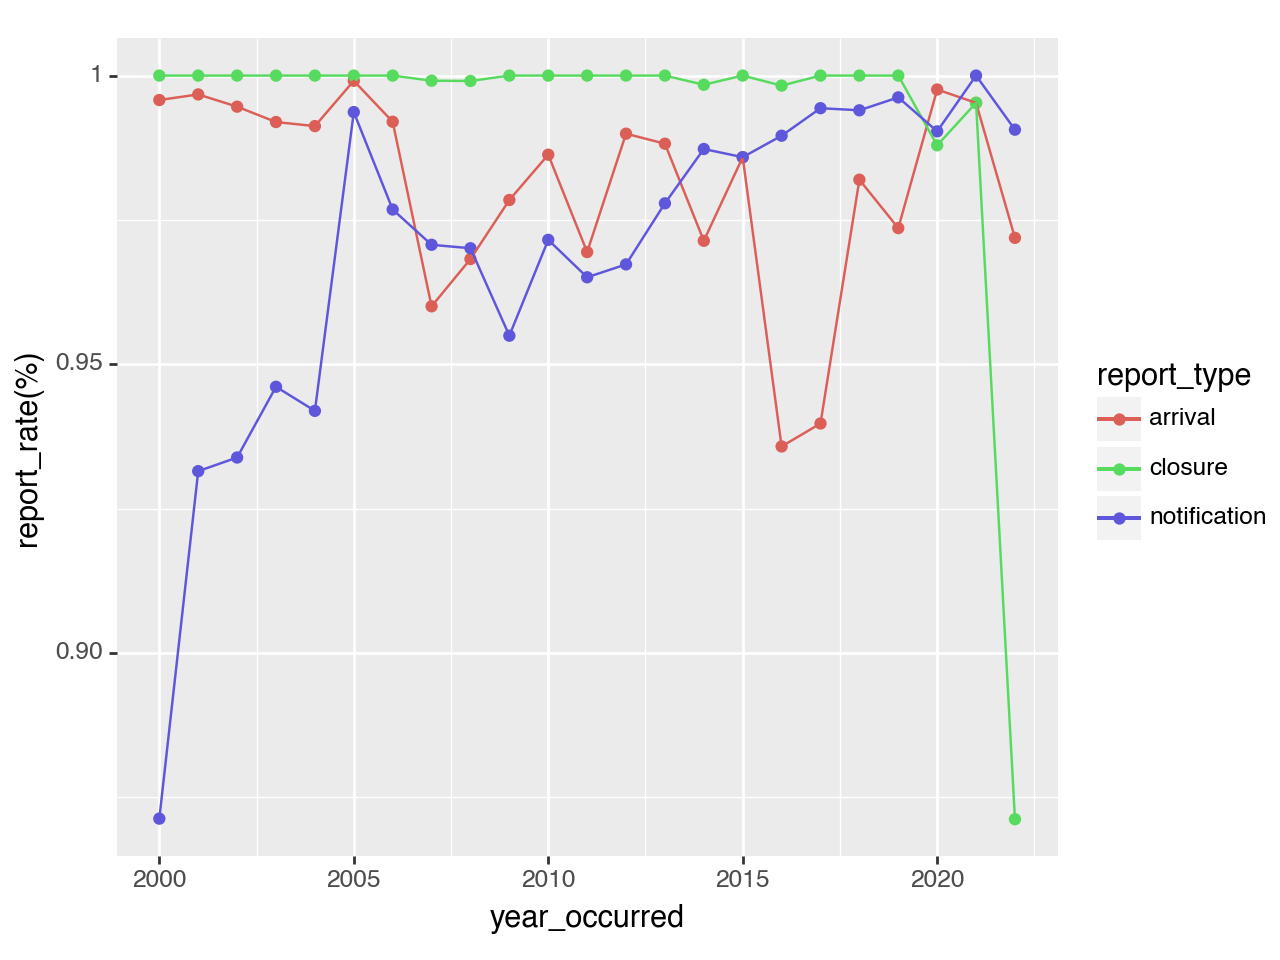

<Figure Size: (640 x 480)>

In [41]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '8', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 9

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

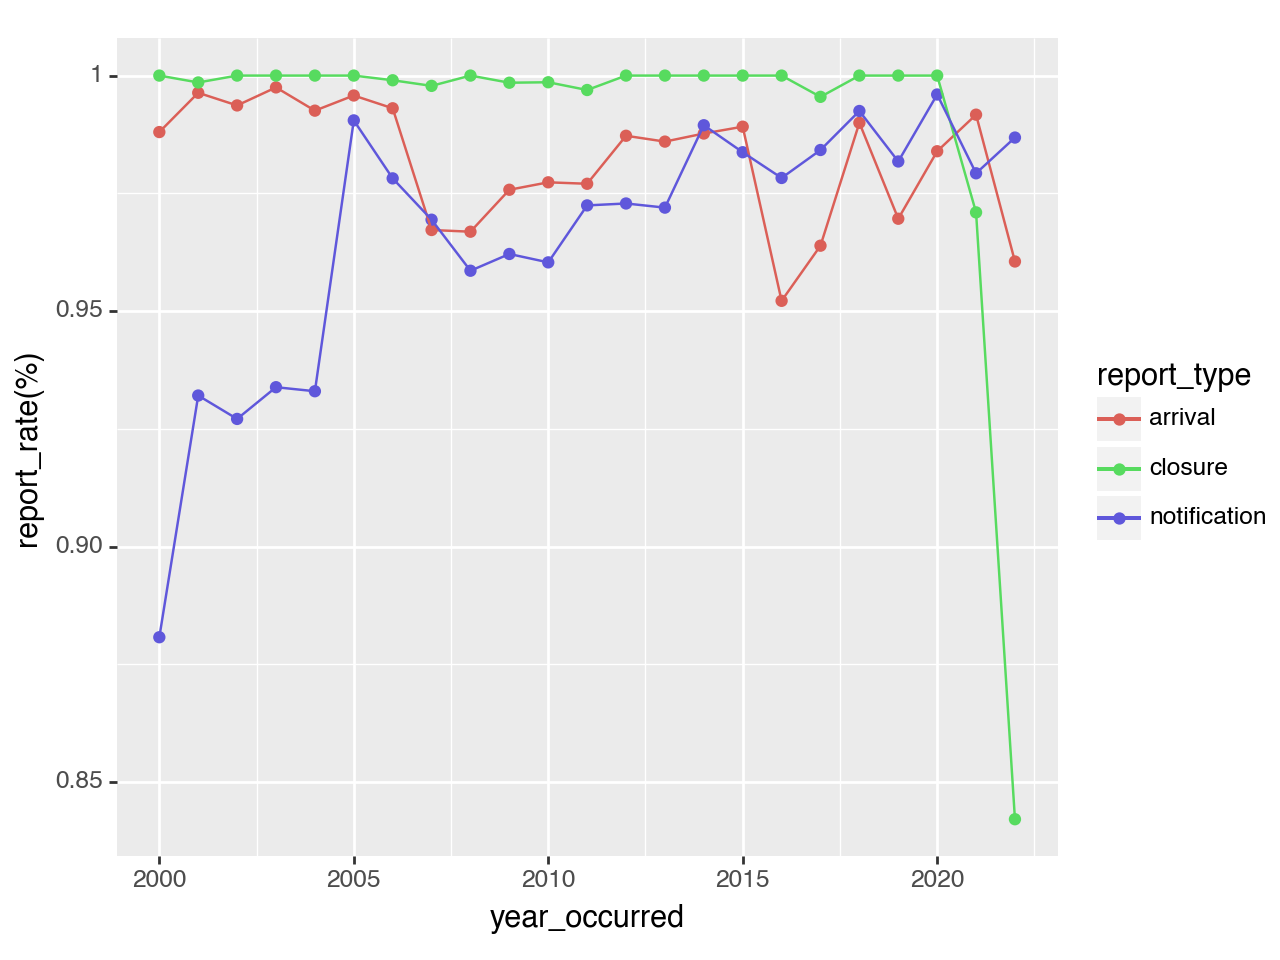

<Figure Size: (640 x 480)>

In [42]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '9', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 10

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

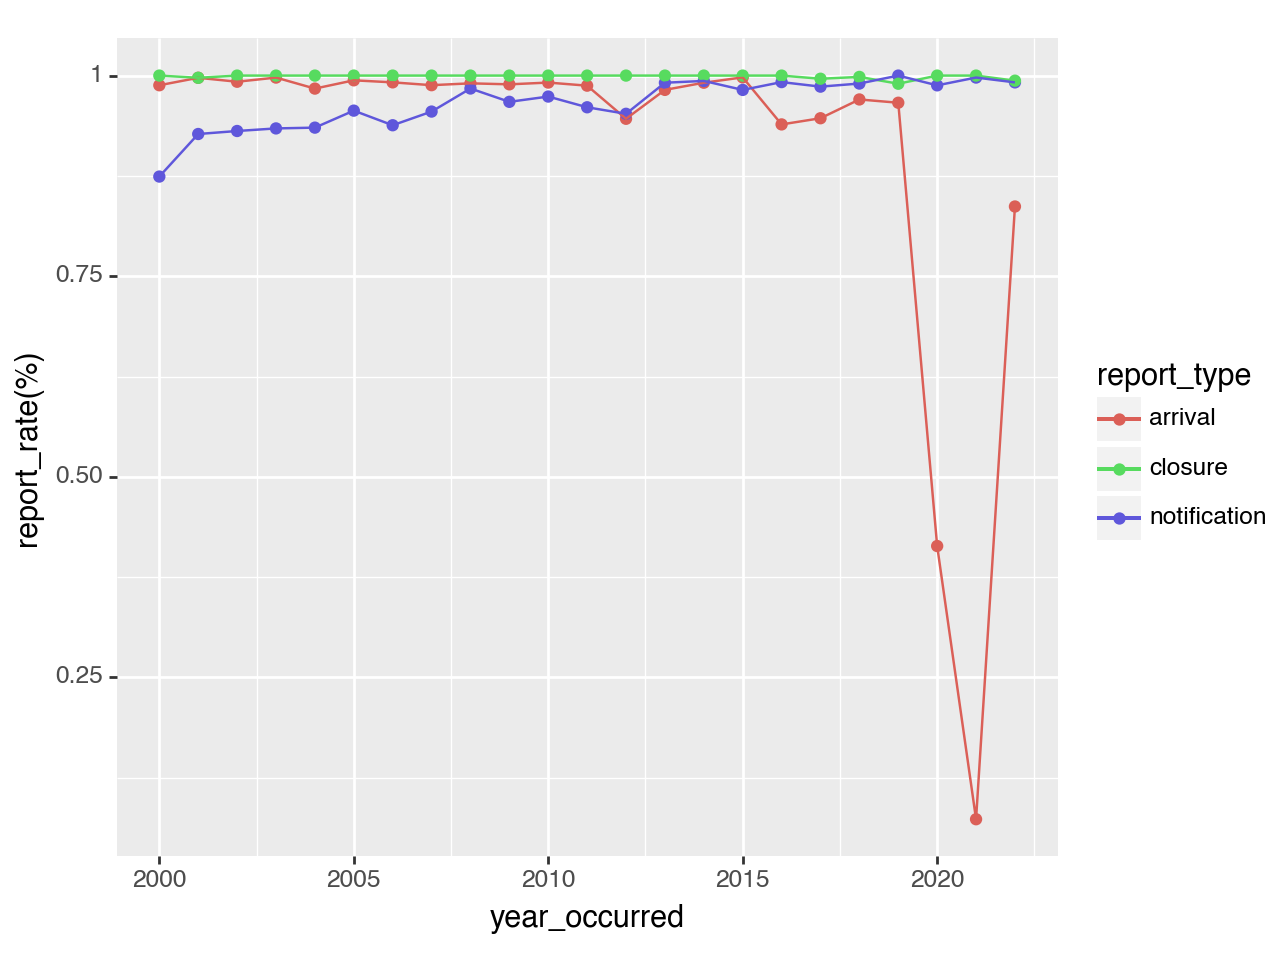

<Figure Size: (640 x 480)>

In [43]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '10', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 11

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

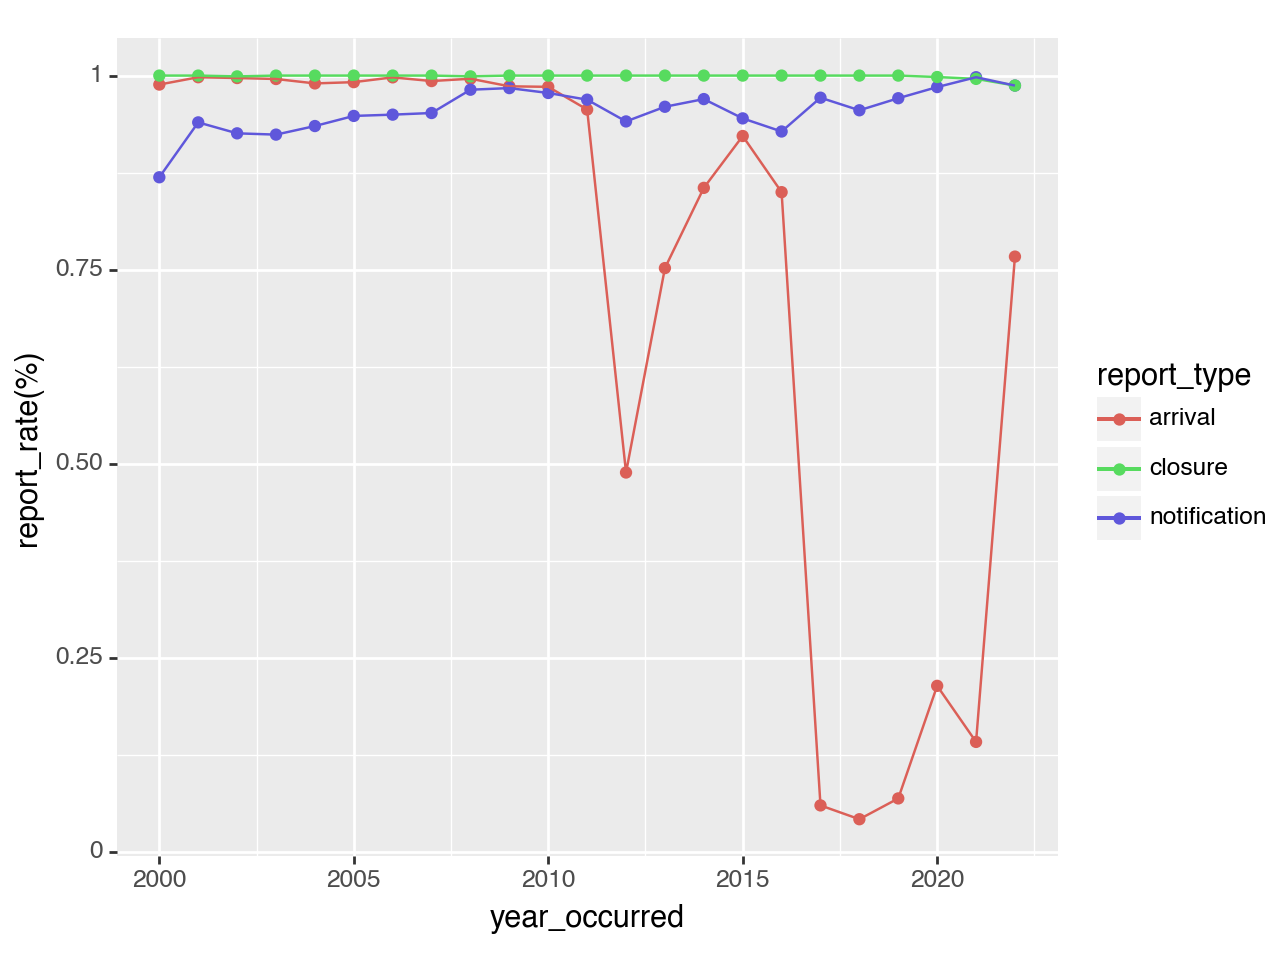

<Figure Size: (640 x 480)>

In [44]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '11', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 12

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

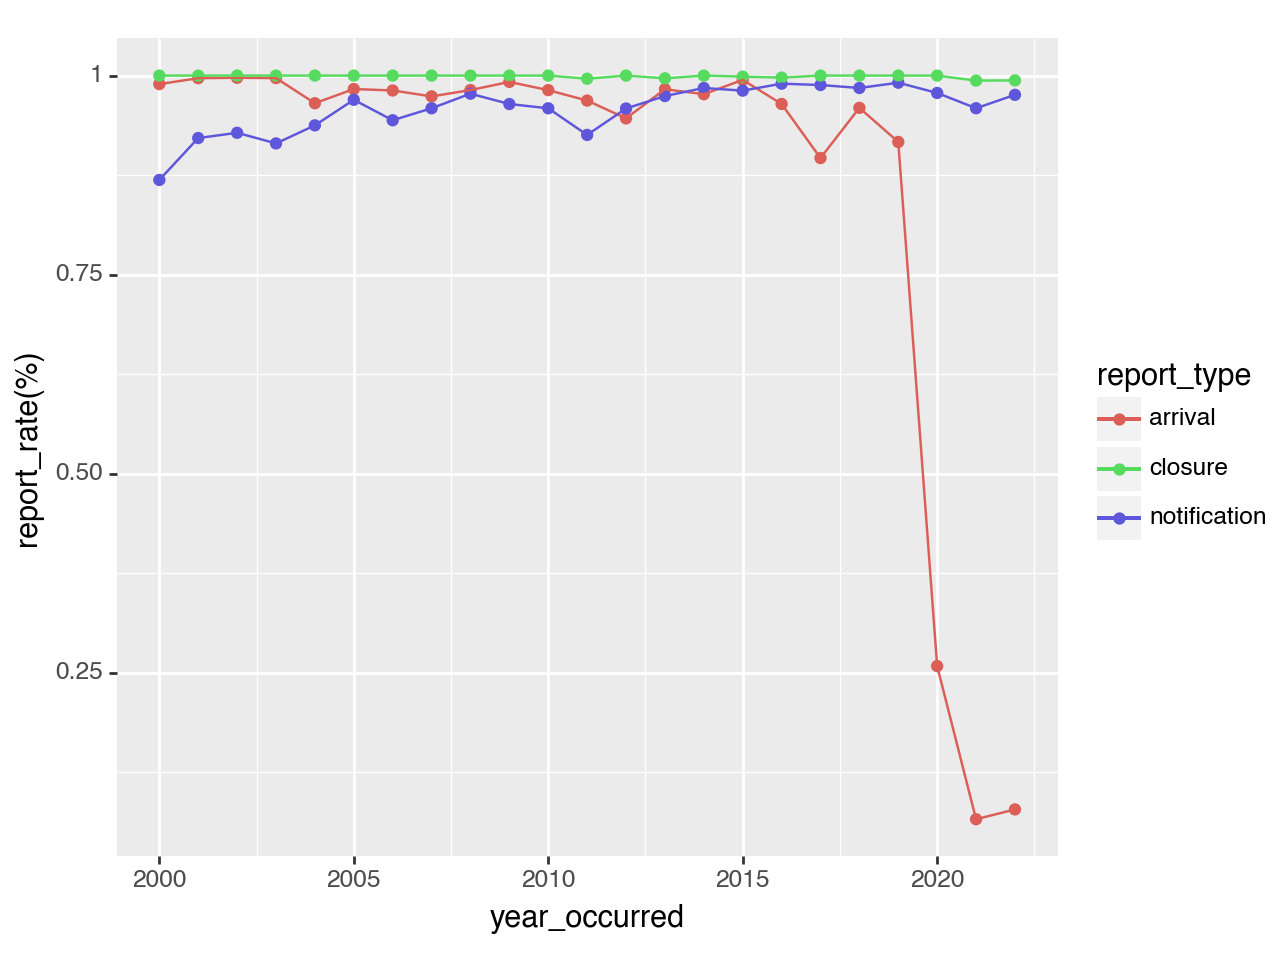

<Figure Size: (640 x 480)>

In [45]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '12', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 13

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

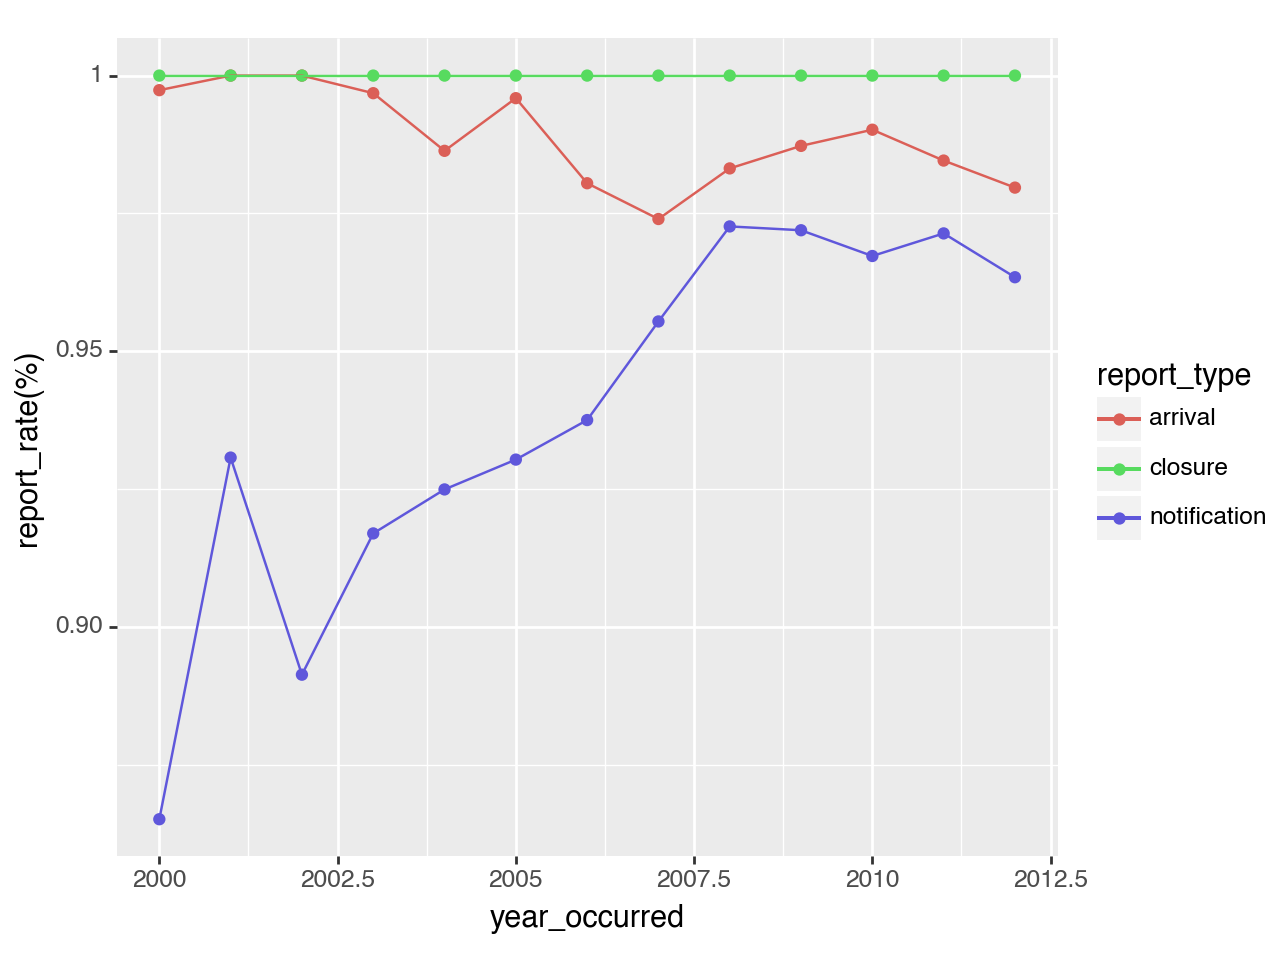

<Figure Size: (640 x 480)>

In [46]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '13', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 14

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

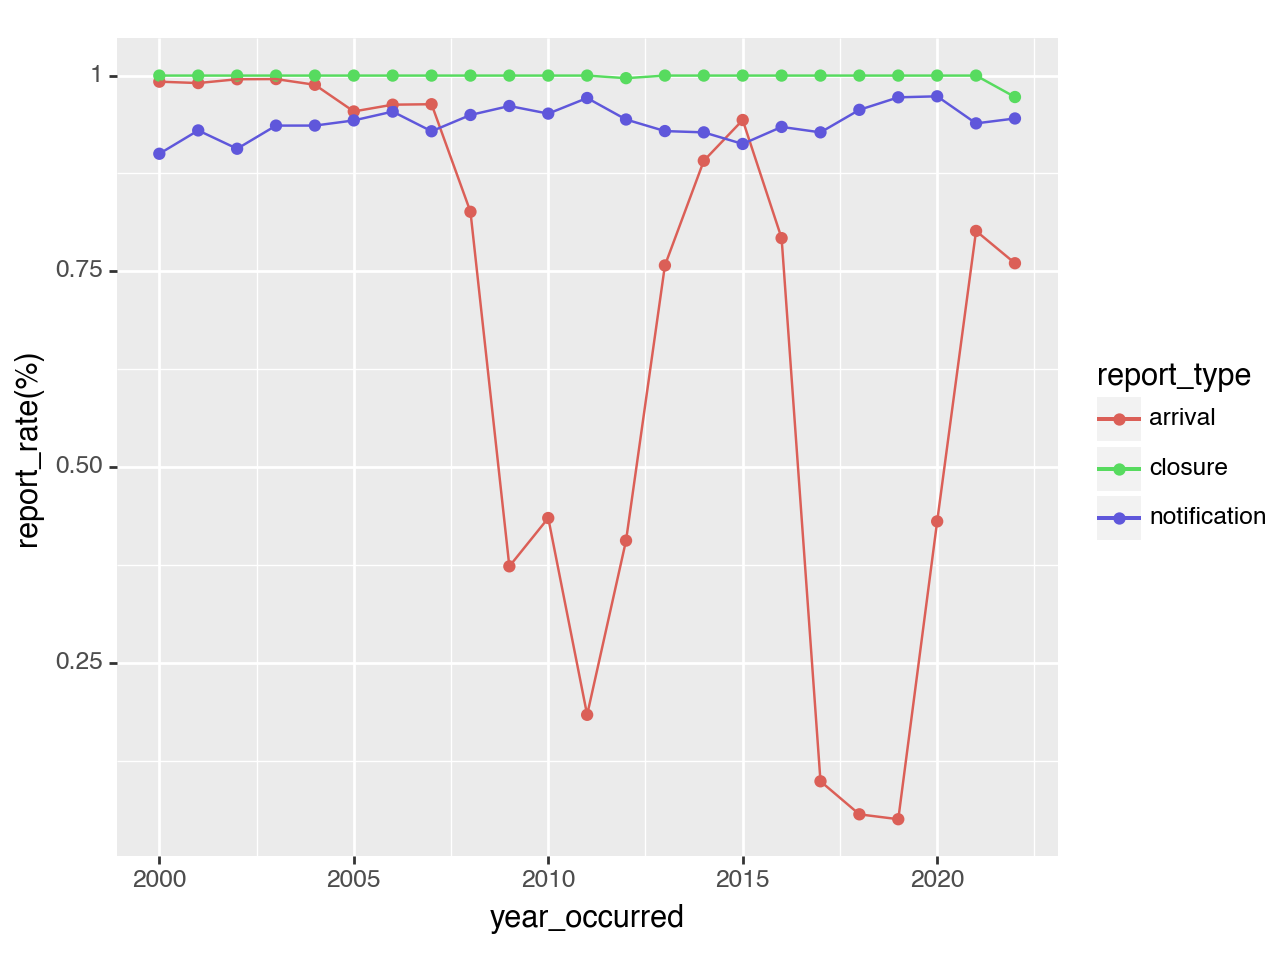

<Figure Size: (640 x 480)>

In [47]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '14', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 15

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

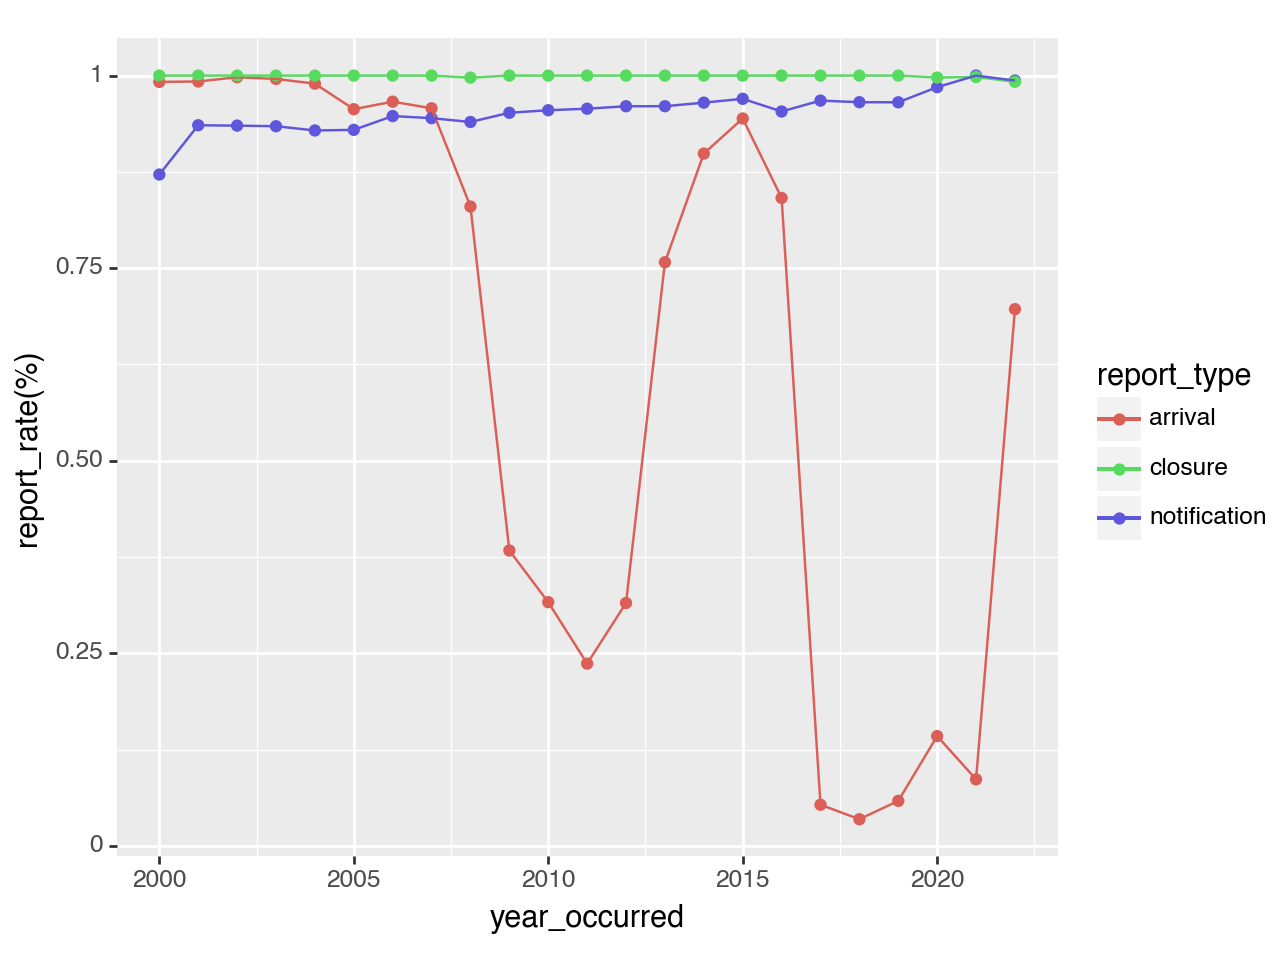

<Figure Size: (640 x 480)>

In [48]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '15', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 16

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

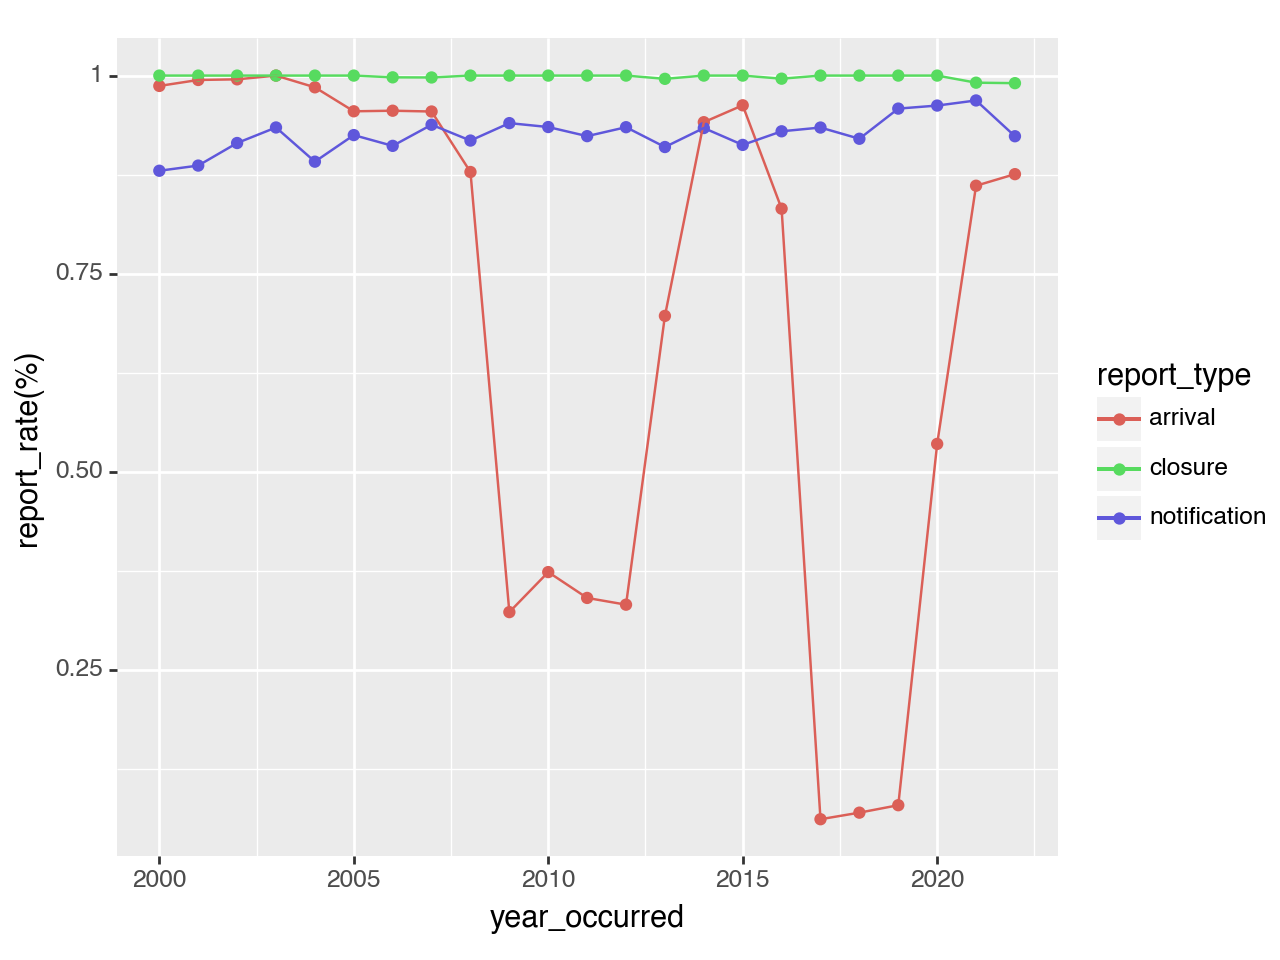

<Figure Size: (640 x 480)>

In [49]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '16', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 17

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

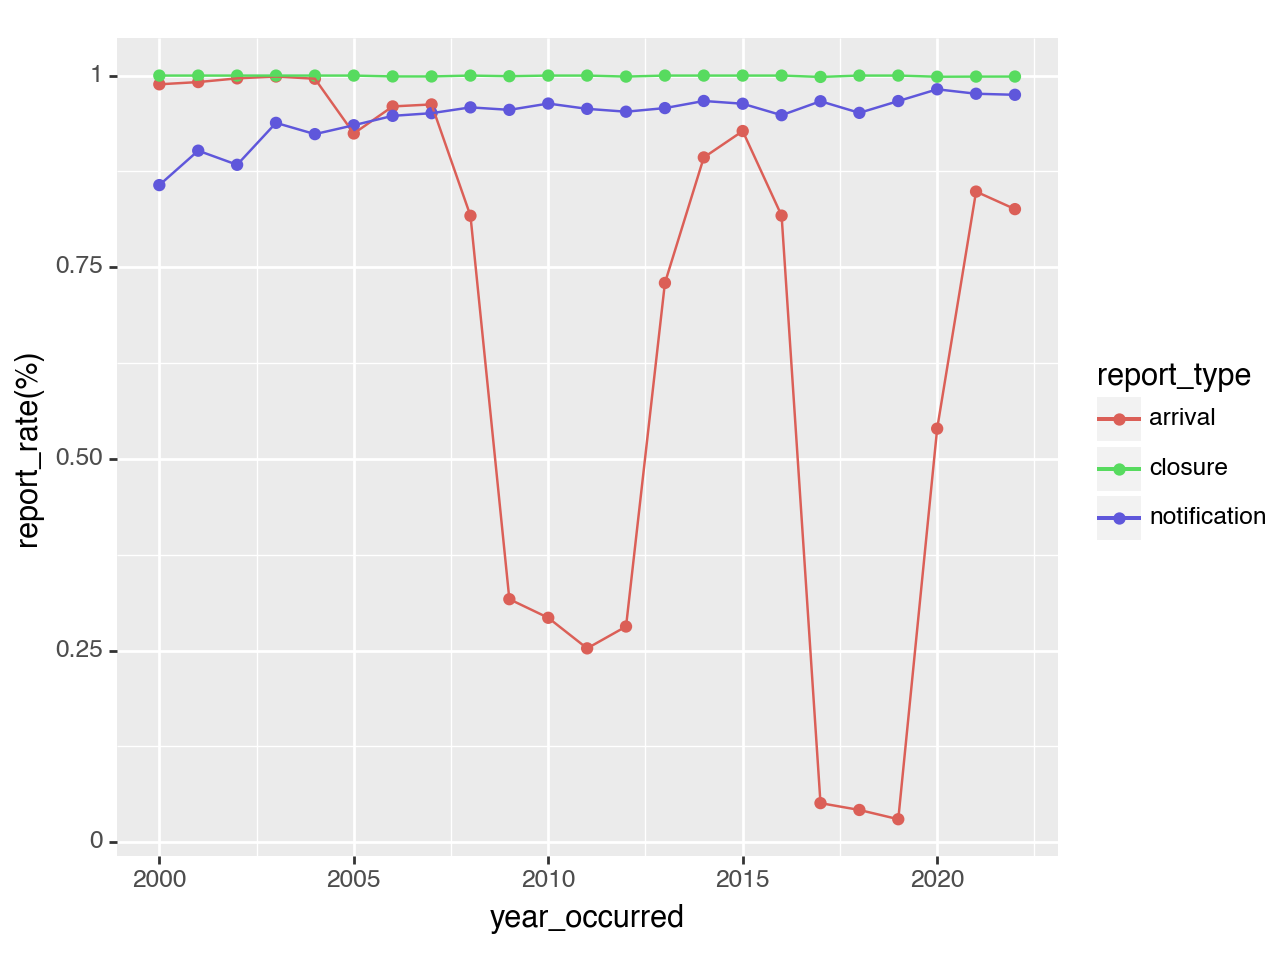

<Figure Size: (640 x 480)>

In [50]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '17', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 18

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

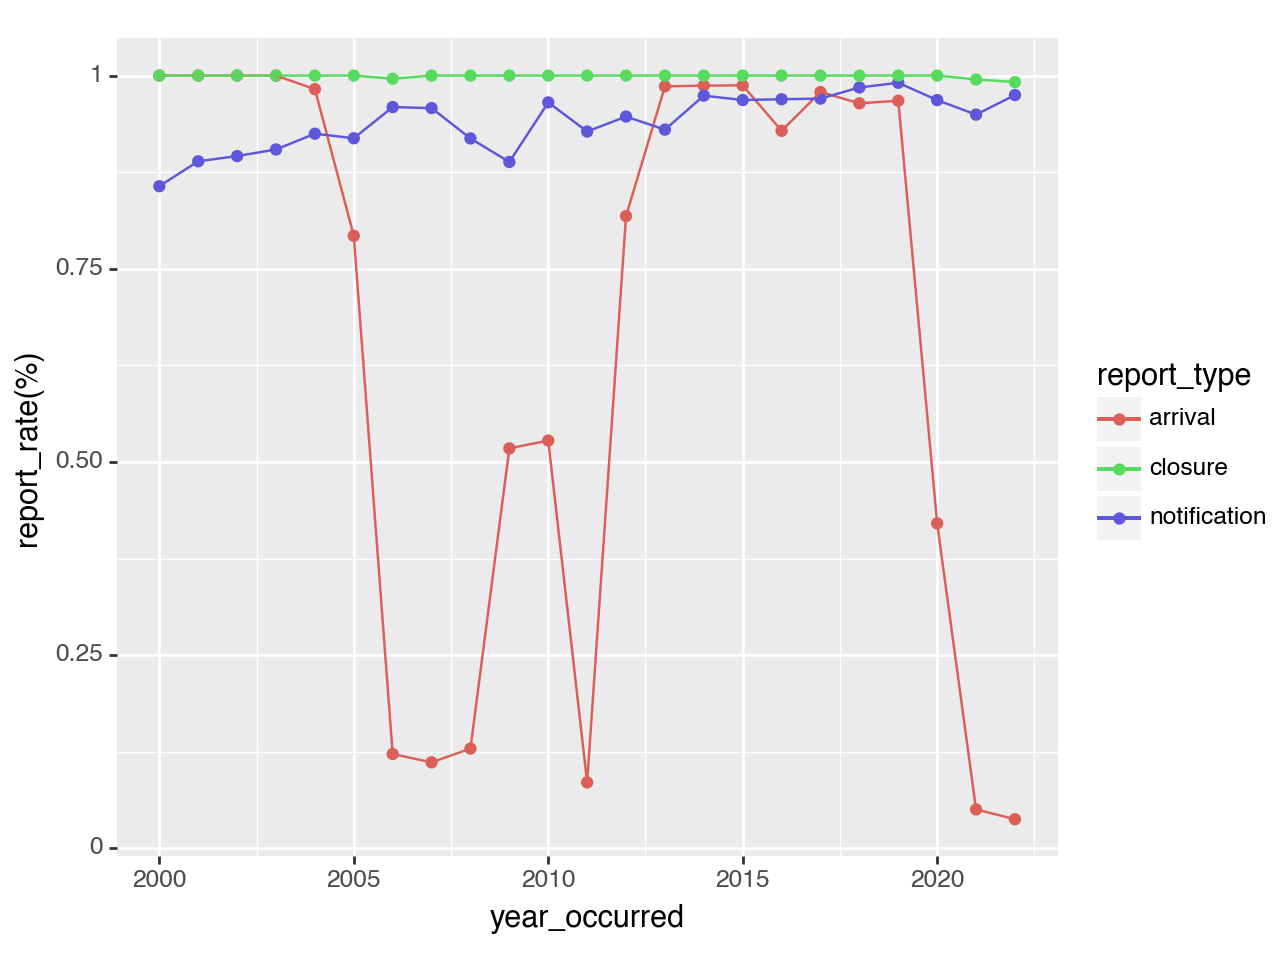

<Figure Size: (640 x 480)>

In [51]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '18', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 19

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

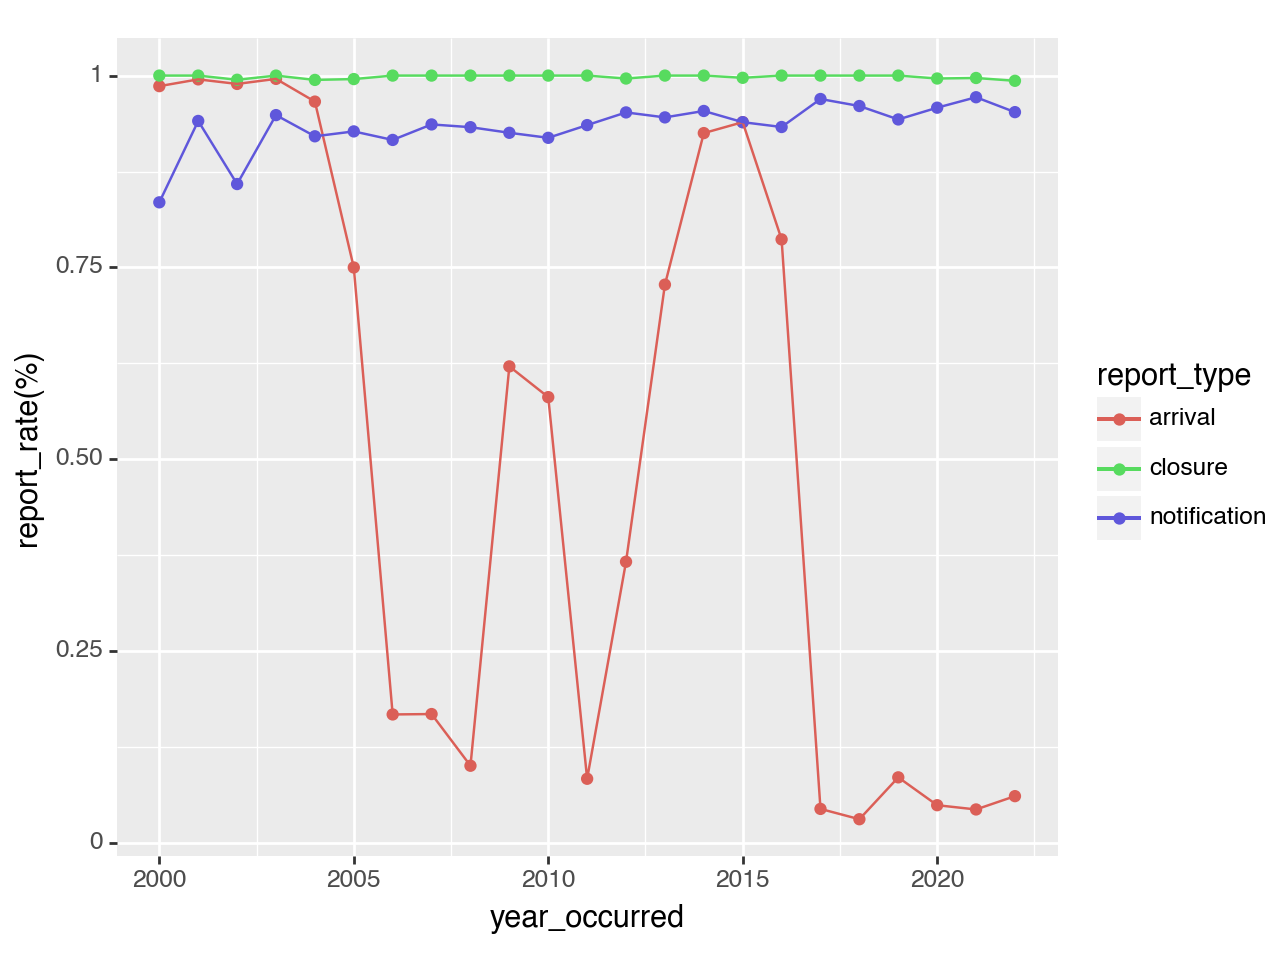

<Figure Size: (640 x 480)>

In [52]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '19', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 20

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

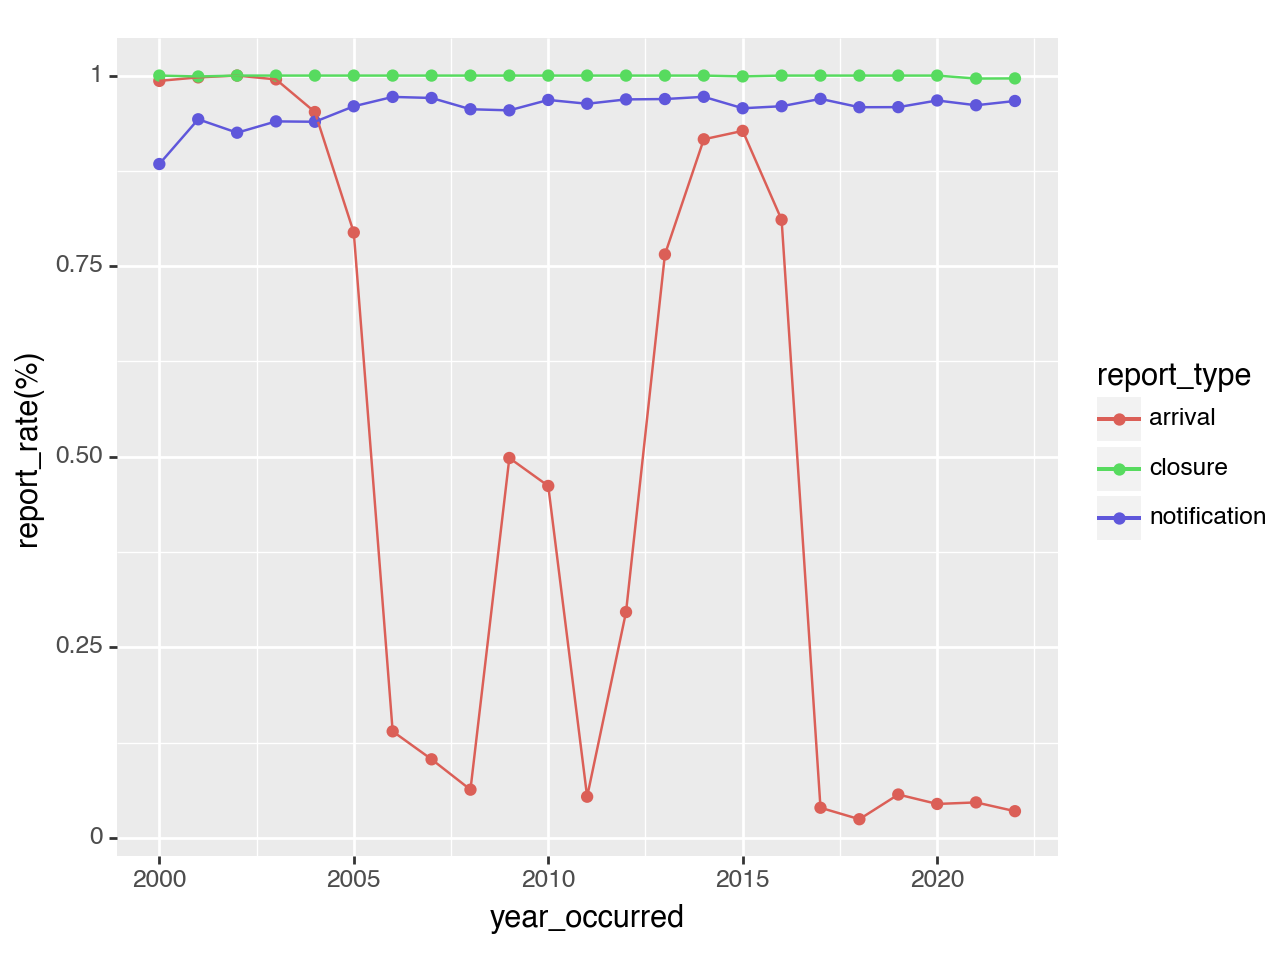

<Figure Size: (640 x 480)>

In [53]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '20', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 21

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

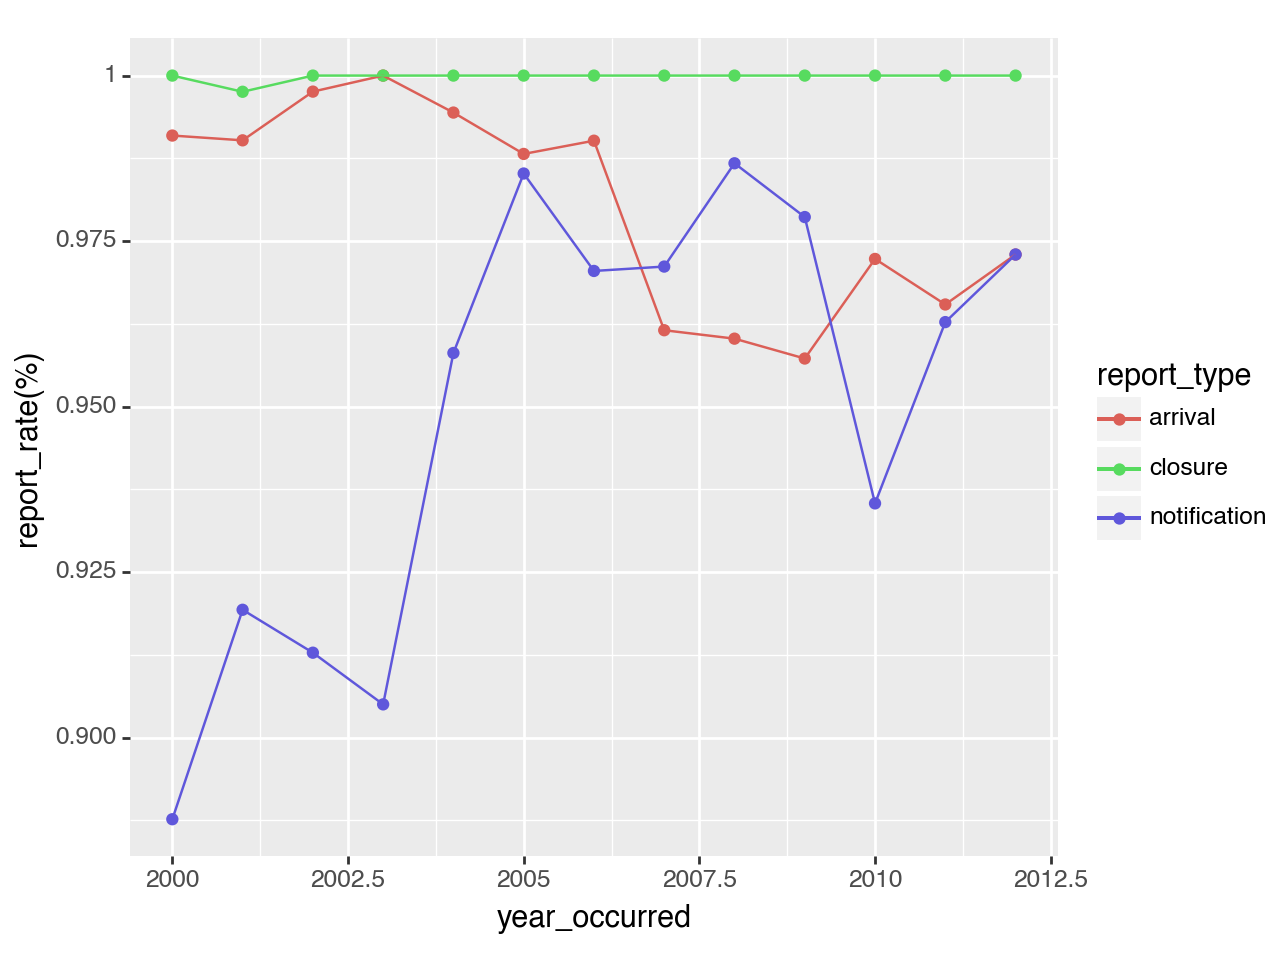

<Figure Size: (640 x 480)>

In [54]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '21', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 22

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

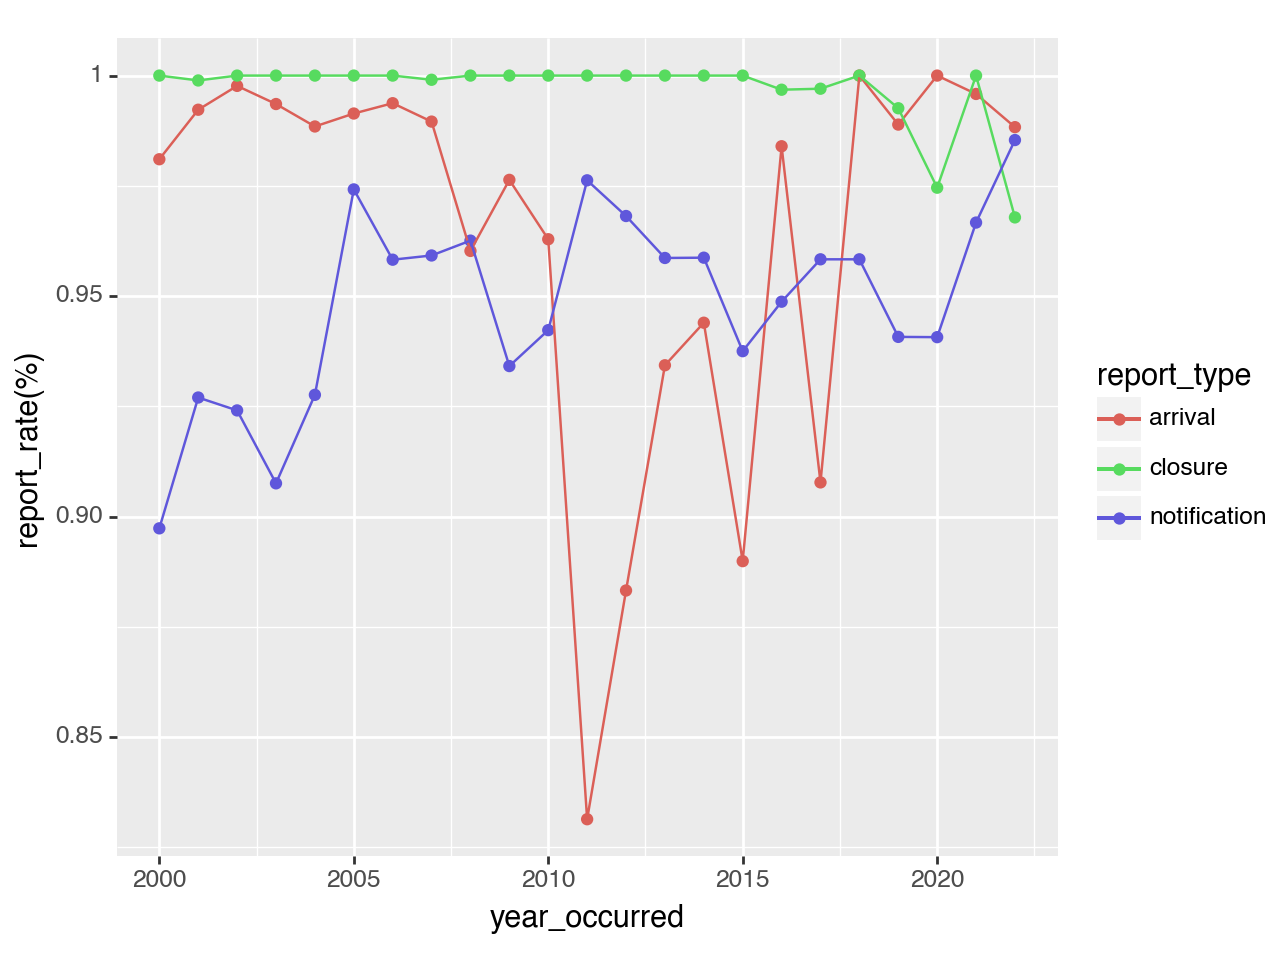

<Figure Size: (640 x 480)>

In [55]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '22', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 23

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

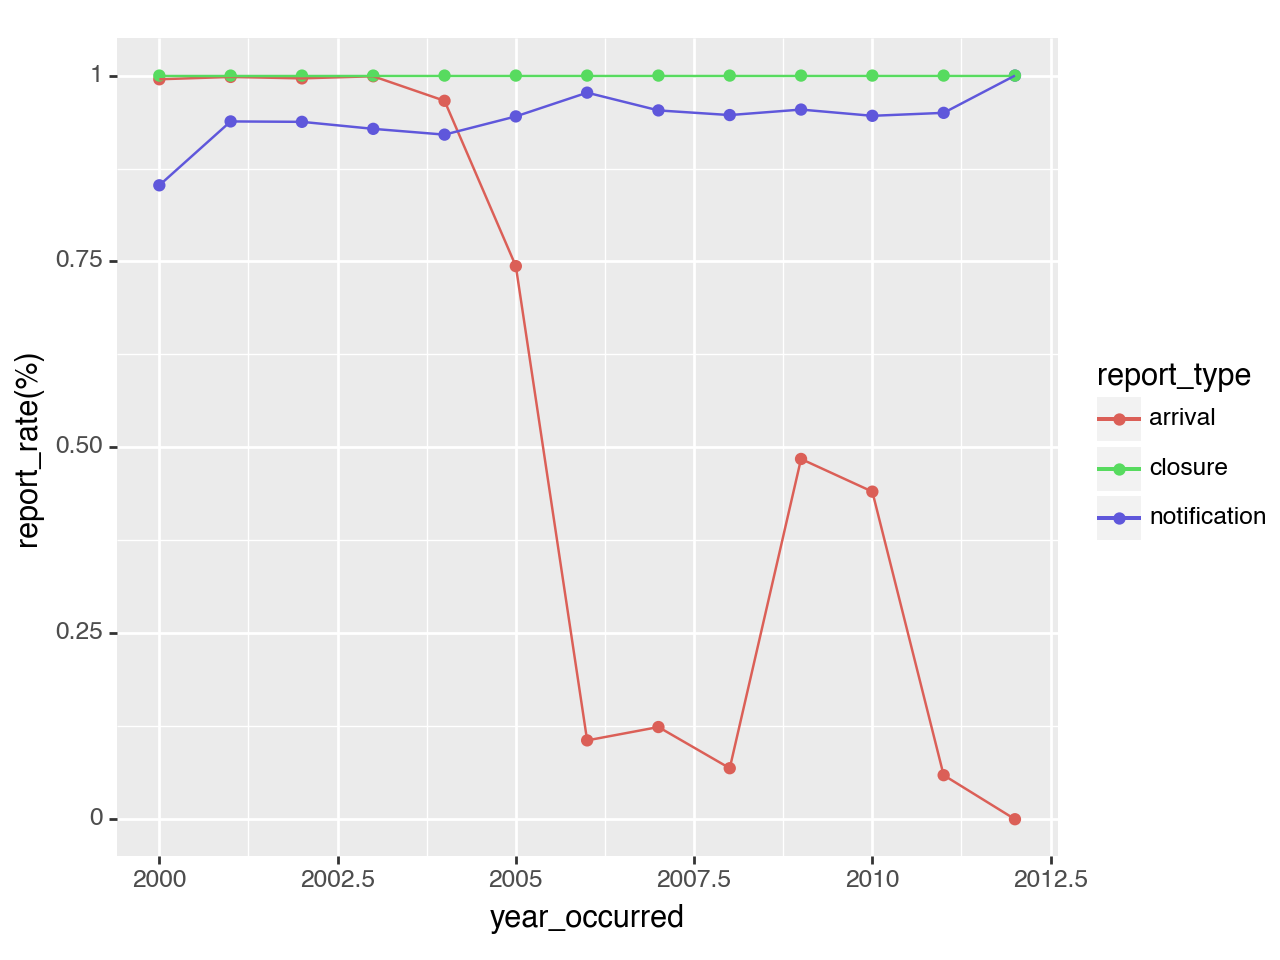

<Figure Size: (640 x 480)>

In [56]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '23', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 24

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

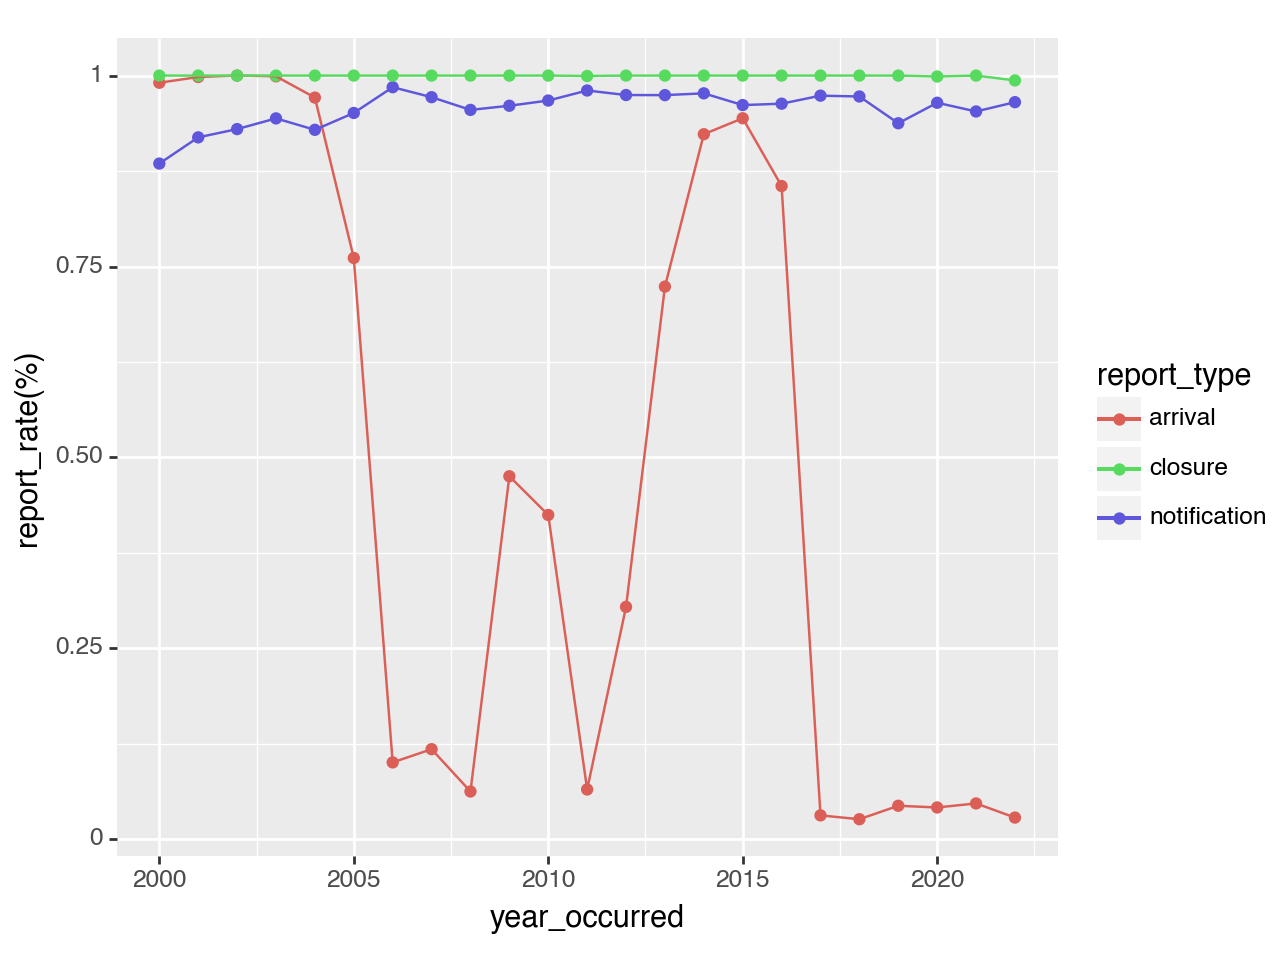

<Figure Size: (640 x 480)>

In [57]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '24', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())

### district 25

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py

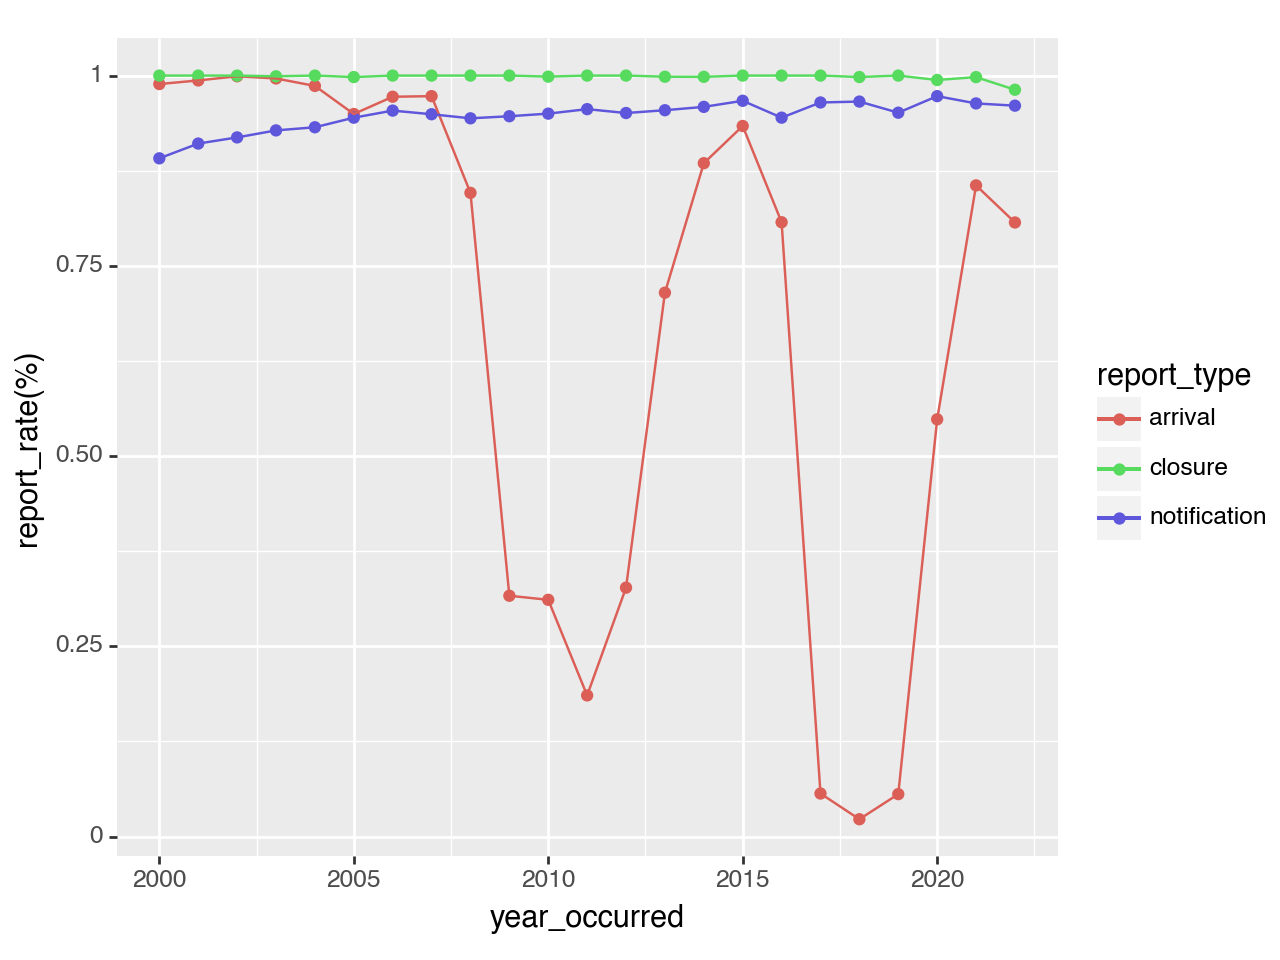

<Figure Size: (640 x 480)>

In [58]:
df = report_rates_tidy.loc[report_rates_tidy.city_district_occurred == '25', 
                           ['year_occurred', 'report_type', 'report_rate(%)']]
(ggplot(df)
 + aes('year_occurred', 'report_rate(%)', color='report_type', group='report_type')
 + geom_point()
 + geom_line())